# PROYECTO TEAMSIGHT, CÁLCULO DEL ATTRITION
# (Sección de Probabilidad) (MAIN CODE)

## Adrián Chacón Candia
## BIMEX Analytics

# ESQUEMA TREBALL TFM

1. Mirar correlacions entre variables i attrition
    1. Reduïr el nombre de variables havent observat les correlacions
    2. Buscar correlacions entre diferents variables?
        1. Mateixes distribucions = es pot desconsiderar una de elles
2. Machine Learning per a reduïr una segona vegada el nombre de dades
3. Machine Learning per a fer prediccions responent a la pregunta: attrition?Yes/No

Esquema cíclic. Potser s'ha de reproduir més d'un cop per a tenir millors resultats.

# REWIND ACTUAL

- Anteriormente: considerando todas las categorías que tienen una correlación >.1 (#14)
    - Dentro de estas agrupamos las que tienen distribuciones similares (#3 parejas +1)
        - Miramos correlación entre las distribuciones generales, dado esto por ahora sólo agrupamos #1 pareja
        
**Variables de este método: 13** (primera limpieza)

- Luego de esta limpieza miramos la matriz de correlación y dendogram (clustering) para tener otros métodos de selección.
- También miramos otros métodos de correlación para tener una mejor selección. El primero de los alternativos és el Principal Components Analysis (PCA). Perdiendo un 25% de la información dada por la covarianza podemos prescindir de la mitat de las variables (de 28 a 14).

**A partir de este punto empezamos a utilizar One Hot Encoding para poder estudiar el DataFrame también con sus variables categóricas**

- Luego de hacer los dos métodos de correlation y PCA calculamos un threshold value para saber qué correlaciones son suficientemente significativas para ser considerarlas (si su valor de correlación es inferior a este threshold significa que esta variable da una información igual a la que podría dar un random guess). También, para PCA, dibujamos una learning curve para ver a partir de que vectores empezamos a ganar poca información.
    - Esto nos da que la correlación debe ser >`threshold_value` para que sea significativo su valor.
    - También viendo la learning curve podemos ver cuando esta pierde más pendiente.

**Variables de este método (correlation): 28**

**Variables de este método (PCA): 20**

- Una vez hecho lo anterior nos disponemos a implementar los dos sistemas a un modelo de machine learning, en este caso, `RandomForest`.

- Visto que los resultados no son del todo satisfactorios también se intenta hacer una predicción ahora con los dos modelos juntos para ver si con más variables hace una mejor predicción.

# DUBTES

- Quins marges són significatius? (valors de la correlació)
    - *Se va como 1/n (en el peor de los casos) o sino 1/sqrt(n), 0.03-0.04 más abajo de eso malo. Puedo hacer un random guess y escoger el valor máximo correlacionado*
- Estudio por departamentos
    - *La red ya lo considera al hacer el caso general. (Lugares donde se equivoca significativo, qué colectivos se equivoca)*
- **Que no haya personas que pesen demasiado**
- Efecto cascada (uno se va, los otros le siguen)
    - *Igual este problema no saca el principal, el primero se va por alguna razón (a considerar si tenemos los datos de ello)*
- Quin és el valor óptim per a PCA?
    - *Mirem quan la Learning Curve s'aplana de manera considerable*
- Quin és el significat de les noves columnes del PCA?
    - *La matriu final que tenim és ja el nou DataFrame amb les noves variables, les variables son vectors de les antigues components.*
- **Qué fer amb els resultats del punt 3?**

# COSES PER A FER

- Estudiar K-Means

# ÍNDEX:

1. [Load libraries and read the data](#1)
2. [Miro correlation values](#2)
    1. [Valores de las categorías más correlacionadas](#2.1)
    2. [Valores de las categorías menos correlacionadas](#2.2)
3. [Similar distributions = similar information](#3)
    1. [Correlation Matrix](#3.1)
4. [Dendrogram](#4)
5. [Principal Components Analysis](#5)
    1. [Standarization](#5.1)
    2. [Covariance Matrix Computation](#5.2)
    3. [Eigenvectors and Eigenvalues](#5.3)
    4. [Feature vector or Descarding](#5.4)
    5. [Recast the Data Along the Principal Components](#5.5)
    6. [Build the new matrix for the machine learning](#5.6)
    7. [Learning Curve of PCA](#5.7)
6. [Fuzzy Learning](#6)
7. [Threshold to relevant data](#7)
8. [Machine Learning for the data selection models](#8)
    1. [Machine Learning for Correlation](#8.1)
        1. [Obtaining the DataFrame](#8.1.1)
        2. [Doing the RandomForest](#8.1.2)
        3. [Evaluation of the RandomForest](#8.1.3)
            1. [Train/Test Split](#8.1.3.1)
            2. [Train/Test Split Evaluation](#8.1.3.1)
        4. [Improvement of RandomForest](#8.1.4)
            1. [Balancing Data](#8.1.4.1)
    2. [Machine Learning for PCA](#8.2)
        1. [Doing the RandomForest](#8.2.1)
    3. [Combining Correlation and PCA](#8.3)
        1. [Creating the DataFrame](#8.3.1)
        2. [Doing the RandomForest](#8.3.2)

# ÍNDEX UTILITATS
- [on guardar imatges](#a)
- [llista categories](#b)
- [operation on a whole column of a DataFrame](#c)
- [creating_random_matrix](#d)
- [correlation_max](#e)
- [mean_of_random](#f)
- [dic_responses_of_category](#g)
- [correlation_attrition](#h)
- [draw_confusion_and_metrics](#i)

## 1. Load libraries and read the data <a class="anchor" id="1"></a>

In [1]:
# Python libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
import xgboost as xgb
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

warnings.filterwarnings('ignore')

import seaborn as sns

In [2]:
data = pd.read_csv('./WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [3]:
data #misma data que en el excel de attrition

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


In [4]:
#voy a cambiar los valores de ATTRITION: Yes,No a los valores Yes:1, No:0
data_n = data
data_n = data_n.set_index('Attrition')
data_n = data_n.rename({"Yes":1,"No":0})
data_n = data_n.reset_index()
data_n = data_n.set_index('Gender')
data_n = data_n.rename({"Male":1,"Female":-1})
data_n = data_n.reset_index()
data_n = data_n.set_index('OverTime')
data_n = data_n.rename({"Yes":1,"No":0})
data_n = data_n.reset_index()
data_n = data_n.set_index('BusinessTravel')
data_n = data_n.rename({"Non-Travel":0,"Travel_Rarely":0.5,"Travel_Frequently":1})
data_n = data_n.reset_index()
#sí coherente Marital_Status?
data_n = data_n.set_index('MaritalStatus')
data_n = data_n.rename({"Single":0,"Divorced":0.5,"Married":1})
data_n = data_n.reset_index()
#clear nonrelevant data
data_n = data_n.drop(columns=['EmployeeCount','StandardHours','Over18'])

data_n

,MaritalStatus,BusinessTravel,OverTime,Gender,Attrition,Age,DailyRate,Department,DistanceFromHome,Education,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.0,0.5,1,-1,1,41,1102,Sales,1,2,...,3,1,0,8,0,1,6,4,0,5
1,1.0,1.0,0,1,0,49,279,Research & Development,8,1,...,4,4,1,10,3,3,10,7,1,7
2,0.0,0.5,1,1,1,37,1373,Research & Development,2,2,...,3,2,0,7,3,3,0,0,0,0
3,1.0,1.0,1,-1,0,33,1392,Research & Development,3,4,...,3,3,0,8,3,3,8,7,3,0
4,1.0,0.5,0,1,0,27,591,Research & Development,2,1,...,3,4,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,1.0,1.0,0,1,0,36,884,Research & Development,23,2,...,3,3,1,17,3,3,5,2,0,3
1466,1.0,0.5,0,1,0,39,613,Research & Development,6,1,...,3,1,1,9,5,3,7,7,1,7
1467,1.0,0.5,1,1,0,27,155,Research & Development,4,3,...,4,2,1,6,0,3,6,2,0,3
1468,1.0,1.0,0,1,0,49,1023,Sales,2,3,...,3,4,0,17,3,2,9,6,0,8


## 2. Miro correlation values <a class="anchor" id="2"></a>

In [5]:
attrition = data_n['Attrition']
age = data_n['Age']

r = age.corr(attrition) # Pearson's r
rho = attrition.corr(age, method='spearman')  # Spearman's rho
#teóricamente Spearman's sirve para que valores muy alejados no afecten tanto
tau = age.corr(attrition, method='kendall')   # Kendall's tau
print(r,rho,tau)

-0.15920500686577968 -0.17121415703713502 -0.14201222845253333


In [6]:
#generalizo para todas las variables:

lista_categorias = []

for i in data_n:
    #print(i)
    if i != 'Attrition':
        lista_categorias.append(i)
    
correlation_dic = {}
lista_categorias_str = []

for category in lista_categorias:
    try:
        r = attrition.corr(data_n[category]) # Pearson's r
        rho = attrition.corr(data_n[category], method='spearman')  # Spearman's rho
        tau = attrition.corr(data_n[category], method='kendall')   # Kendall's tau
        #print(r,rho,tau)
        correlation_dic[category] = [r,rho,tau]
    except:
        #print(category) #categories we need to make values of
        lista_categorias_str.append(category)
        
    
correlation_dic

{'MaritalStatus': [-0.1459853687036999,
  -0.14040929484366013,
  -0.13305848627265024],
 'BusinessTravel': [0.1270064831524362,
  0.12763597530048107,
  0.12371169744221036],
 'OverTime': [0.24611799424580427, 0.24611799424580436, 0.24611799424580433],
 'Gender': [0.029453253175141657, 0.029453253175141657, 0.029453253175141653],
 'Age': [-0.15920500686577965, -0.17121415703713502, -0.14201222845253333],
 'DailyRate': [-0.056651991867629294,
  -0.05696969110631772,
  -0.04654870664451371],
 'DistanceFromHome': [0.07792358295570373,
  0.07924818605616858,
  0.06676468094899914],
 'Education': [-0.031372819640049295,
  -0.030345907897881566,
  -0.02781707651822803],
 'EmployeeNumber': [-0.010577242759243148,
  -0.010368617013903764,
  -0.008468819422789412],
 'EnvironmentSatisfaction': [-0.10336897833793608,
  -0.09648641952769646,
  -0.08837667820597055],
 'HourlyRate': [-0.006845549572139845,
  -0.0066922825637718815,
  -0.005504082640481823],
 'JobInvolvement': [-0.13001595678605354,

In [7]:
max_corr = {}

for category in correlation_dic:
    max_corr[category] = max(correlation_dic[category], key=abs)
    
max_corr

print('Correlation over 10%')
print(' ')

correlation10 = {}

for category in max_corr:
    if abs(max_corr[category]) > .1:
        print(category,max_corr[category])
        correlation10[category] = max_corr[category]
        
print('----------------')

correlation15 = {}

print('Correlation over 15%')
print(' ')

for category in max_corr:
    if abs(max_corr[category]) >= .15:
        print(category,max_corr[category])
        correlation15[category] = max_corr[category]

Correlation over 10%
 
MaritalStatus -0.1459853687036999
BusinessTravel 0.12763597530048107
OverTime 0.24611799424580436
Age -0.17121415703713502
EnvironmentSatisfaction -0.10336897833793608
JobInvolvement -0.13001595678605354
JobLevel -0.19037042396815798
JobSatisfaction -0.10348112606902142
MonthlyIncome -0.19830500478881555
StockOptionLevel -0.17229579976178383
TotalWorkingYears -0.19900201964525882
YearsAtCompany -0.19041909827240788
YearsInCurrentRole -0.1806230299708929
YearsWithCurrManager -0.17535508134266475
----------------
Correlation over 15%
 
OverTime 0.24611799424580436
Age -0.17121415703713502
JobLevel -0.19037042396815798
MonthlyIncome -0.19830500478881555
StockOptionLevel -0.17229579976178383
TotalWorkingYears -0.19900201964525882
YearsAtCompany -0.19041909827240788
YearsInCurrentRole -0.1806230299708929
YearsWithCurrManager -0.17535508134266475


##### correlation_attrition <a class="anchor" id="h"></a>

Funció que, donat un DataFrame (que conté una columna de la variable Attrition), et dona la correlació que tenen totes les diferents variables respecte l'attrition.

In [8]:
def correlation_attrition(data_n):  

    lista_categorias = llista_categories(data_n)

    correlation_dic = {}
    lista_categorias_str = []

    for category in lista_categorias:
        try:
            r = attrition.corr(data_n[category]) # Pearson's r
            rho = attrition.corr(data_n[category], method='spearman')  # Spearman's rho
            tau = attrition.corr(data_n[category], method='kendall')   # Kendall's tau
            #print(r,rho,tau)
            correlation_dic[category] = [r,rho,tau]
        except:
            #print(category) #categories we need to make values of
            lista_categorias_str.append(category)


    #correlation_dic

    max_corr = {}

    for category in correlation_dic:
        max_corr[category] = max(correlation_dic[category], key=abs)

    return(max_corr,lista_categorias_str)

###### on guardar imatges <a class="anchor" id="a"></a>

Path a copiar per a guardar les imatges en el lloc corresponent

In [9]:
#PARA GUARDAR LAS FIGURAS USAR:
figures_path = '/Users/Adrian/Documents/Estudio/Màster/Segundo_Semestre/TFM/Attrition/Figures/'

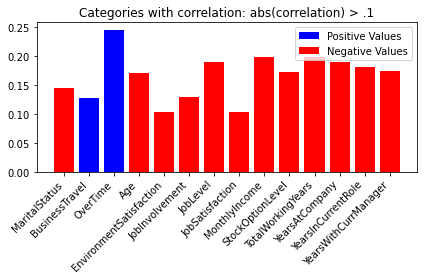

In [10]:
import matplotlib.pyplot as plt

plt.title('Categories with correlation: abs(correlation) > .1')
plt.xticks(rotation = 45, ha="right")
colors = []
values10 = []
for i in correlation10.values():
    if i > 0:
        colors.append('blue')
    else:
        colors.append('red')   
        
    values10.append(abs(i))
    
plt.bar(list(correlation10.keys()), values10, color = 'blue', label = 'Positive Values')
plt.bar(list(correlation10.keys()), values10, color = colors, label = 'Negative Values')
plt.legend()
plt.tight_layout()
plt.savefig(figures_path+'Correlation_over10.png')
plt.show()

## 2.1 $\uparrow$ Valores de las categorías más correlacionadas $\uparrow$ <a class="anchor" id="2.1"></a>

In [11]:
lista_categorias_str 
#miro si hay alguna de estas categorías que puedo convertir porque
#son interesantes

['Department', 'EducationField', 'JobRole']

In [12]:
data[data.Age <18]
data_n.Department.value_counts()
#data_n.EducationField.value_counts()
#data_n.JobRole.value_counts()
#data_n.MaritalStatus.value_counts() #?

Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64

## 2.2 $\downarrow$ Valores de las categorías menos correlacionadas $\downarrow$ <a class="anchor" id="2.2"></a>

In [13]:
print('Correlation under 5%')
print(' ')

for category in max_corr:
    if abs(max_corr[category]) <= .05:
        print(category,max_corr[category])

Correlation under 5%
 
Gender 0.029453253175141657
Education -0.031372819640049295
EmployeeNumber -0.010577242759243148
HourlyRate -0.006845549572139845
MonthlyRate 0.015257582997484679
NumCompaniesWorked 0.04349373905781359
PercentSalaryHike -0.023612035124358322
PerformanceRating 0.0028887517110807955
RelationshipSatisfaction -0.04587227888112664


## 3. Similar distributions = similar information <a class="anchor" id="3"></a>
## Thus, we can dismiss one of them

In [14]:
print(len(correlation10),'variables (primera limpieza)')
correlation10

14 variables (primera limpieza)


{'MaritalStatus': -0.1459853687036999,
 'BusinessTravel': 0.12763597530048107,
 'OverTime': 0.24611799424580436,
 'Age': -0.17121415703713502,
 'EnvironmentSatisfaction': -0.10336897833793608,
 'JobInvolvement': -0.13001595678605354,
 'JobLevel': -0.19037042396815798,
 'JobSatisfaction': -0.10348112606902142,
 'MonthlyIncome': -0.19830500478881555,
 'StockOptionLevel': -0.17229579976178383,
 'TotalWorkingYears': -0.19900201964525882,
 'YearsAtCompany': -0.19041909827240788,
 'YearsInCurrentRole': -0.1806230299708929,
 'YearsWithCurrManager': -0.17535508134266475}

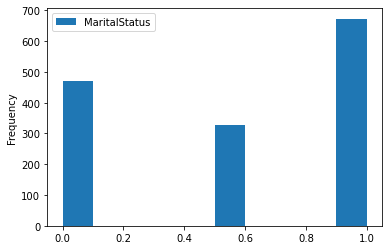

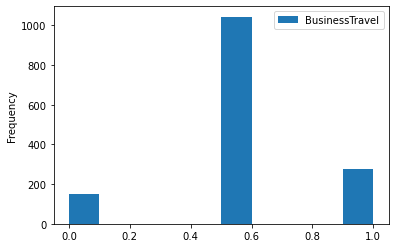

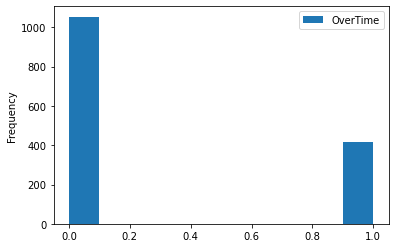

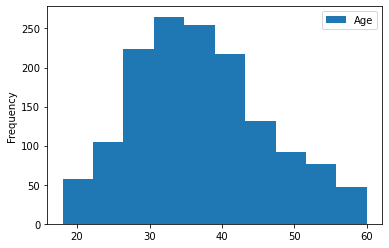

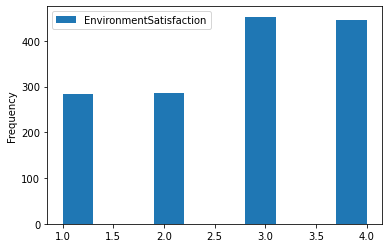

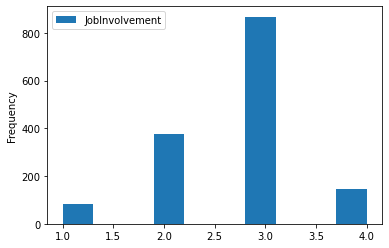

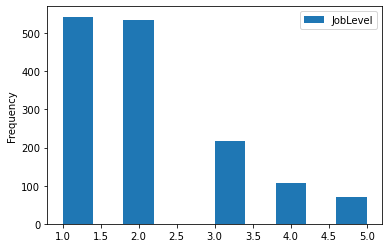

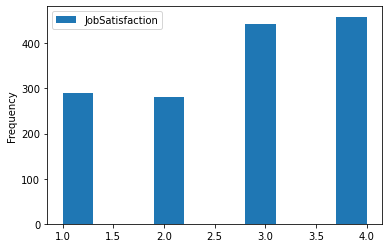

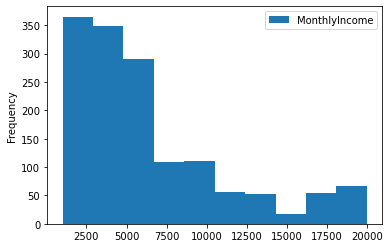

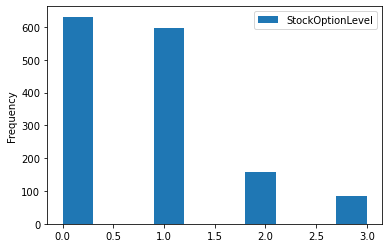

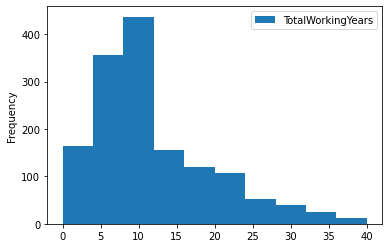

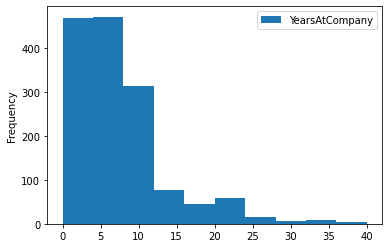

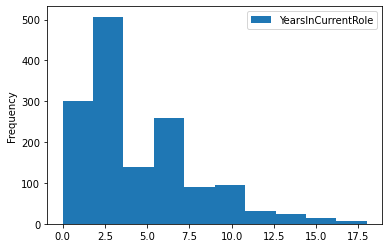

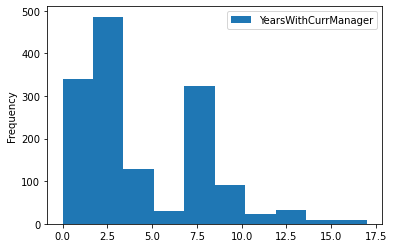

In [15]:
#data_age = data_n.loc[:,['Attrition','Age']]
#data_age = data_age.set_index('Attrition')
#data_age.plot.hist()

for category in correlation10:
    data_cat = data_n.loc[:,['Attrition',category]]
    data_cat = data_cat.set_index('Attrition')
    data_cat.plot.hist()
    plt.savefig(figures_path+category+'_freq_of_attrition.png')

### Similar distributions que encontré (correlation does not mean causation):

- Environment Satisfaction vs Job Satisfaction
- Job Level vs Stock Option Level
- Years In Current Role vs Years With Current Manager
- *Total Working Years vs Years At Company?*

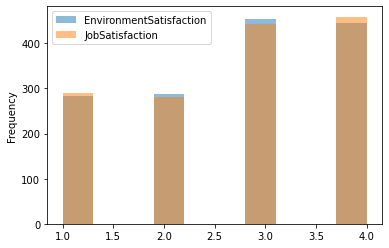

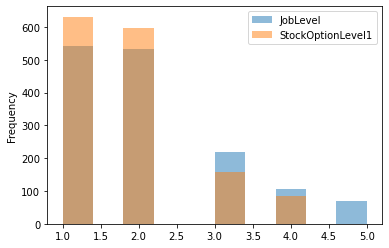

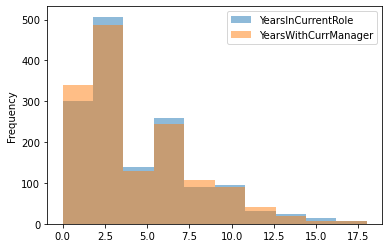

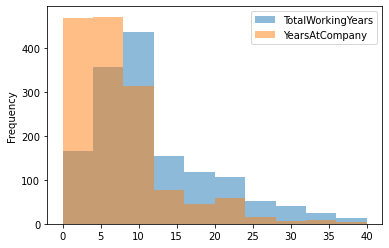

In [16]:
data_cat = data_n.loc[:,['Attrition','EnvironmentSatisfaction','JobSatisfaction']]
data_cat = data_cat.set_index('Attrition')
data_cat.plot.hist(alpha=0.5)
plt.savefig(figures_path+'EnvSat_JobSat.png')

#para ver mejor la correlación entre JobLevel y StockOptionLevel
#desfasamos los valores de StockOptionLevel +1
data_corr = data_n
data_corr['StockOptionLevel1'] = data_n.loc[:,['StockOptionLevel']]
data_corr['Phase'] = 1
data_corr['StockOptionLevel1'] = data_corr[['StockOptionLevel','Phase']].sum(axis=1)
data_corr.drop(columns=['Phase'])
#data_corr.loc[:,['StockOptionLevel','StockOptionLevel1']]

data_cat = data_corr.loc[:,['Attrition','JobLevel','StockOptionLevel1']]
data_cat = data_cat.set_index('Attrition')
data_cat.plot.hist(alpha=0.5)
plt.savefig(figures_path+'JobLev_StockOptLv.png')

data_cat = data_n.loc[:,['Attrition','YearsInCurrentRole','YearsWithCurrManager']]
data_cat = data_cat.set_index('Attrition')
data_cat.plot.hist(alpha=0.5)
plt.savefig(figures_path+'YCurrRole_YWithCurrMan.png')

data_cat = data_n.loc[:,['Attrition','TotalWorkingYears','YearsAtCompany']]
data_cat = data_cat.set_index('Attrition')
data_cat.plot.hist(alpha=0.5)
plt.savefig(figures_path+'TotWorkYears_YearsAtComp.png')

Salen resultados bastante similares excepto para *TotalWorkingYears vs YearsAtCompany*.
Ahora calcularé las correlaciones entre ellas a ver si salen valores significativos.

In [17]:
#generalizo para todas las variables:

categorias_corr = {'EnvironmentSatisfaction':'JobSatisfaction',
                   'JobLevel':'StockOptionLevel1',
                  'YearsInCurrentRole':'YearsWithCurrManager',
                   'TotalWorkingYears':'YearsAtCompany'}
    
correlation_dic_variables = {}

for category in categorias_corr:
    r = data_corr[category].corr(data_corr[categorias_corr[category]]) # Pearson's r
    rho = data_corr[category].corr(data_corr[categorias_corr[category]], method='spearman')  # Spearman's rho
    tau = data_corr[category].corr(data_corr[categorias_corr[category]], method='kendall')   # Kendall's tau
    #print(r,rho,tau)
    correlation_dic_variables[category+'_'+categorias_corr[category]] = [r,rho,tau]
        
    
correlation_dic_variables
max_corr_variables = {}

for category in correlation_dic_variables:
    #print(correlation_dic_variables[category])
    max_corr_variables[category] = max(correlation_dic_variables[category], key=abs)
    
max_corr_variables

{'EnvironmentSatisfaction_JobSatisfaction': -0.006784352599075094,
 'JobLevel_StockOptionLevel1': 0.047786169932748465,
 'YearsInCurrentRole_YearsWithCurrManager': 0.7247542192761358,
 'TotalWorkingYears_YearsAtCompany': 0.628133155268246}

In [18]:
r = data_corr['EnvironmentSatisfaction'].corr(data_corr['JobSatisfaction'])
r #pese a tener distribuciones muy similares la gente responde al caso particular diferente

data_corr.loc[data_corr['EnvironmentSatisfaction'] == data_corr['JobSatisfaction']]

,MaritalStatus,BusinessTravel,OverTime,Gender,Attrition,Age,DailyRate,Department,DistanceFromHome,Education,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,StockOptionLevel1,Phase
5,0.0,1.0,0,1,0,32,1005,Research & Development,2,2,...,0,8,2,2,7,7,3,6,1,1
9,1.0,0.5,0,1,0,36,1299,Research & Development,27,3,...,2,17,3,2,7,7,7,7,3,1
14,0.0,0.5,1,1,1,28,103,Research & Development,24,3,...,0,6,4,3,4,2,0,3,1,1
17,0.5,0.0,1,1,0,22,1123,Research & Development,16,2,...,2,1,2,2,1,0,0,0,3,1
19,0.0,0.5,1,1,0,38,371,Research & Development,2,3,...,0,6,3,3,3,2,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,0.5,0.0,0,1,0,36,301,Sales,15,4,...,1,15,4,2,15,12,11,11,2,1
1455,0.0,0.5,0,1,0,40,1322,Research & Development,2,4,...,0,8,2,3,2,2,2,2,1,1
1456,1.0,1.0,1,1,0,35,1199,Research & Development,18,4,...,2,10,2,4,10,2,0,2,3,1
1457,1.0,0.5,0,-1,0,40,1194,Research & Development,2,4,...,3,20,2,3,5,3,0,2,4,1


In [19]:
print('Sólo un',382/1470*100,'% responden igual a las dos preguntas particularmente')
print('Pero las cantidades son casi iguales a nivel grupal')

Sólo un 25.98639455782313 % responden igual a las dos preguntas particularmente
Pero las cantidades son casi iguales a nivel grupal


$\textbf{Las únicas variables que puedo considerar similares por ahora es}$ $\textit{YearsInCurrentRole con YearsWithCurrManager}$

In [20]:
r = data_corr['YearsInCurrentRole'].corr(data_corr['YearsWithCurrManager'])
r #pese a tener distribuciones muy similares la gente responde al caso particular diferente

data_corr.loc[data_corr['YearsInCurrentRole'] == data_corr['YearsWithCurrManager']]

,MaritalStatus,BusinessTravel,OverTime,Gender,Attrition,Age,DailyRate,Department,DistanceFromHome,Education,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,StockOptionLevel1,Phase
1,1.0,1.0,0,1,0,49,279,Research & Development,8,1,...,1,10,3,3,10,7,1,7,2,1
2,0.0,0.5,1,1,1,37,1373,Research & Development,2,2,...,0,7,3,3,0,0,0,0,1,1
4,1.0,0.5,0,1,0,27,591,Research & Development,2,1,...,1,6,3,3,2,2,2,2,2,1
6,1.0,0.5,1,-1,0,59,1324,Research & Development,3,3,...,3,12,3,2,1,0,0,0,4,1
7,0.5,0.5,0,1,0,30,1358,Research & Development,24,1,...,1,1,2,3,1,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.0,0.5,0,1,0,40,1322,Research & Development,2,4,...,0,8,2,3,2,2,2,2,1,1
1456,1.0,1.0,1,1,0,35,1199,Research & Development,18,4,...,2,10,2,4,10,2,0,2,3,1
1459,1.0,0.5,1,1,0,29,1378,Research & Development,13,2,...,1,10,2,3,4,3,0,3,2,1
1460,0.0,0.5,0,-1,0,29,468,Research & Development,28,4,...,0,5,3,1,5,4,0,4,1,1


In [21]:
print('Un',668/1470*100,'% responden igual a las dos preguntas particularmente')
#print('Pero las cantidades son casi iguales a nivel grupal')

Un 45.442176870748305 % responden igual a las dos preguntas particularmente


In [22]:
print('Similar distributions and correlation =',
      max_corr_variables['YearsInCurrentRole_YearsWithCurrManager'])

Similar distributions and correlation = 0.7247542192761358


## 3.1 Correlation Matrix <a class="anchor" id="3.1"></a>

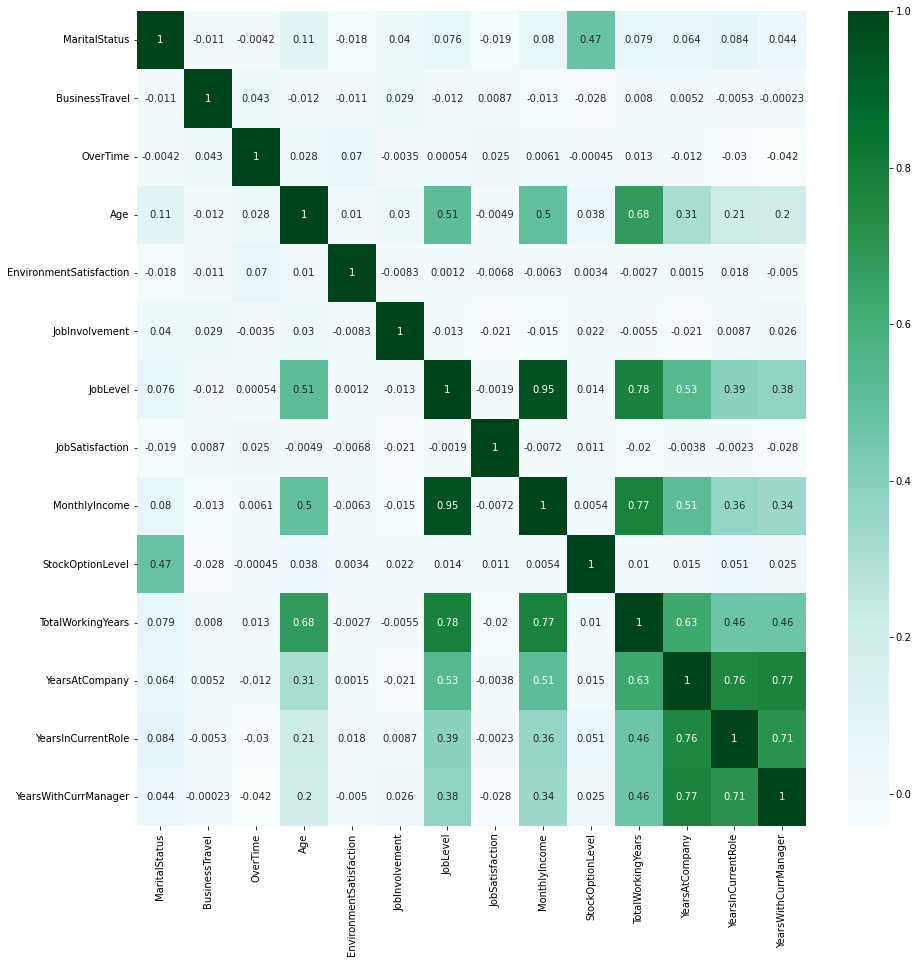

In [23]:
# Pearson Correlation Matrix
plt.figure(figsize = (15, 15))
corr_mat = data_n[correlation10].corr()
sns.heatmap(corr_mat, xticklabels = corr_mat.columns, 
            yticklabels = corr_mat.columns, annot=True, cmap='BuGn')
plt.savefig(figures_path+'CorrelationMatrix.png')

## 4. Dendrogram <a class="anchor" id="4"></a>

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

%matplotlib inline

In [25]:
#utilizo df data_corr
#data_corr.info()

data_dendrogram = data_corr.loc[:,correlation10.keys()].transpose().values
data_dendrogram
data_dendrogram.shape

(14, 1470)

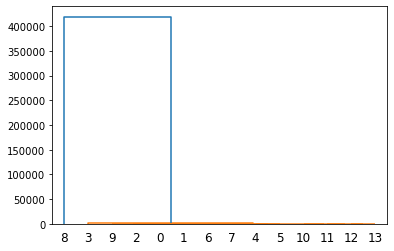

In [26]:
Clustering_Jerarquico = linkage(data_dendrogram,'ward') 
#utilizamos el método ward para agrupar los clusters
dendrogram = sch.dendrogram(Clustering_Jerarquico)

In [27]:
#creamos los clusters
clusters_dic = {}
for i in correlation10:
    clusters_dic[i] = []

n_clusters = 14
for t_value in range(10,2000):
    clusters = fcluster(Clustering_Jerarquico, t=t_value ,criterion='distance')
    #t es la altura a la que queremos que haga el corte el dendrograma
    n_clusters_t = 0
    for i in clusters:
        if i > n_clusters_t:
            n_clusters_t = i
            
    if n_clusters_t < n_clusters or n_clusters == 14:
        n_clusters -= 1
        for i in range(0,len(clusters)):
            clusters_dic[list(correlation10.keys())[i]].append(clusters[i])
    
    
clusters_dic

{'MaritalStatus': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'BusinessTravel': [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'OverTime': [3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'Age': [13, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
 'EnvironmentSatisfaction': [5, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1],
 'JobInvolvement': [6, 4, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1],
 'JobLevel': [8, 6, 5, 4, 3, 2, 2, 1, 1, 1, 1, 1],
 'JobSatisfaction': [7, 5, 4, 3, 2, 2, 2, 1, 1, 1, 1, 1],
 'MonthlyIncome': [14, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2],
 'StockOptionLevel': [4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'TotalWorkingYears': [12, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 1],
 'YearsAtCompany': [11, 9, 8, 7, 6, 5, 4, 3, 2, 2, 1, 1],
 'YearsInCurrentRole': [9, 7, 6, 5, 4, 3, 3, 2, 2, 2, 1, 1],
 'YearsWithCurrManager': [10, 8, 7, 6, 5, 4, 3, 2, 2, 2, 1, 1]}

In [28]:
for i in clusters_dic:
    clusters_dic[i].reverse()
clusters_dic

{'MaritalStatus': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'BusinessTravel': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
 'OverTime': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
 'Age': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13],
 'EnvironmentSatisfaction': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 5],
 'JobInvolvement': [1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 4, 6],
 'JobLevel': [1, 1, 1, 1, 1, 2, 2, 3, 4, 5, 6, 8],
 'JobSatisfaction': [1, 1, 1, 1, 1, 2, 2, 2, 3, 4, 5, 7],
 'MonthlyIncome': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14],
 'StockOptionLevel': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4],
 'TotalWorkingYears': [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12],
 'YearsAtCompany': [1, 1, 2, 2, 3, 4, 5, 6, 7, 8, 9, 11],
 'YearsInCurrentRole': [1, 1, 2, 2, 2, 3, 3, 4, 5, 6, 7, 9],
 'YearsWithCurrManager': [1, 1, 2, 2, 2, 3, 4, 5, 6, 7, 8, 10]}

In [29]:
listed_clusters = {}
for i in range(2,13):
    listed_clusters[i] = {}
    
for category in clusters_dic:
    for index in range(0,len(clusters_dic[category])-1):
        if clusters_dic[category][index] in listed_clusters[index+2]:
                listed_clusters[index+2][clusters_dic[category][index]].append(category)
        else:
            #print(clusters_dic[category][index])
            listed_clusters[index+2][clusters_dic[category][index]] = [category]
            
listed_clusters
#no hay cluster 13, pasa directo de 12 a 14

{2: {1: ['MaritalStatus',
   'BusinessTravel',
   'OverTime',
   'Age',
   'EnvironmentSatisfaction',
   'JobInvolvement',
   'JobLevel',
   'JobSatisfaction',
   'StockOptionLevel',
   'TotalWorkingYears',
   'YearsAtCompany',
   'YearsInCurrentRole',
   'YearsWithCurrManager'],
  2: ['MonthlyIncome']},
 3: {1: ['MaritalStatus',
   'BusinessTravel',
   'OverTime',
   'EnvironmentSatisfaction',
   'JobInvolvement',
   'JobLevel',
   'JobSatisfaction',
   'StockOptionLevel',
   'TotalWorkingYears',
   'YearsAtCompany',
   'YearsInCurrentRole',
   'YearsWithCurrManager'],
  2: ['Age'],
  3: ['MonthlyIncome']},
 4: {1: ['MaritalStatus',
   'BusinessTravel',
   'OverTime',
   'EnvironmentSatisfaction',
   'JobInvolvement',
   'JobLevel',
   'JobSatisfaction',
   'StockOptionLevel'],
  3: ['Age'],
  4: ['MonthlyIncome'],
  2: ['TotalWorkingYears',
   'YearsAtCompany',
   'YearsInCurrentRole',
   'YearsWithCurrManager']},
 5: {1: ['MaritalStatus',
   'BusinessTravel',
   'OverTime',
   'Envi

## 5. Principal Components Analysis <a class="anchor" id="5"></a>

# THE FINAL MATRIX NEEDS TO BE A 28x(Number of variables we want) OR A TRANSPOSED VERSION OF THAT BECAUSE THIS MATRIX ENABLES US TO CHANGE THE DATAFRAME 

In [30]:
data_n

,MaritalStatus,BusinessTravel,OverTime,Gender,Attrition,Age,DailyRate,Department,DistanceFromHome,Education,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,StockOptionLevel1,Phase
0,0.0,0.5,1,-1,1,41,1102,Sales,1,2,...,0,8,0,1,6,4,0,5,1,1
1,1.0,1.0,0,1,0,49,279,Research & Development,8,1,...,1,10,3,3,10,7,1,7,2,1
2,0.0,0.5,1,1,1,37,1373,Research & Development,2,2,...,0,7,3,3,0,0,0,0,1,1
3,1.0,1.0,1,-1,0,33,1392,Research & Development,3,4,...,0,8,3,3,8,7,3,0,1,1
4,1.0,0.5,0,1,0,27,591,Research & Development,2,1,...,1,6,3,3,2,2,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,1.0,1.0,0,1,0,36,884,Research & Development,23,2,...,1,17,3,3,5,2,0,3,2,1
1466,1.0,0.5,0,1,0,39,613,Research & Development,6,1,...,1,9,5,3,7,7,1,7,2,1
1467,1.0,0.5,1,1,0,27,155,Research & Development,4,3,...,1,6,0,3,6,2,0,3,2,1
1468,1.0,1.0,0,1,0,49,1023,Sales,2,3,...,0,17,3,2,9,6,0,8,1,1


In [31]:
data_n.EducationField.describe()

count              1470
unique                6
top       Life Sciences
freq                606
Name: EducationField, dtype: object

In [32]:
data_n.EmployeeNumber

0          1
1          2
2          4
3          5
4          7
        ... 
1465    2061
1466    2062
1467    2064
1468    2065
1469    2068
Name: EmployeeNumber, Length: 1470, dtype: int64

##### llista categories <a class="anchor" id="b"></a>

Funció que, donada un DataFrame, et retorna les categories (de les columnes) que el composen.

In [33]:
def llista_categories(DataFrame):
    #función que te da las categorías de un DataFrame en una lista

    llista_categories = [category for category in DataFrame]
    
    return(llista_categories)

In [34]:
llista_categories(data_n)
#EducationField
#EmployeeNumber
#Phase
#Department
data_PCA = data_n.drop(columns=['Attrition',
                                'EducationField',
                                'EmployeeNumber',
                                'Phase',
                               'Department',
                               'JobRole'])

### 5.1 Standarization <a class="anchor" id="5.1"></a>

In [35]:
data_PCA.describe()

,MaritalStatus,BusinessTravel,OverTime,Gender,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,StockOptionLevel1
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,0.569048,0.543197,0.282993,0.200000,36.923810,802.485714,9.192517,2.912925,2.721769,65.891156,...,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129,1.793878
std,0.435602,0.266085,0.450606,0.980129,9.135373,403.509100,8.106864,1.024165,1.093082,20.329428,...,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136,0.852077
min,0.000000,0.000000,0.000000,-1.000000,18.000000,102.000000,1.000000,1.000000,1.000000,30.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.500000,0.000000,-1.000000,30.000000,465.000000,2.000000,2.000000,2.000000,48.000000,...,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,1.000000
50%,0.500000,0.500000,0.000000,1.000000,36.000000,802.000000,7.000000,3.000000,3.000000,66.000000,...,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,2.000000
75%,1.000000,0.500000,1.000000,1.000000,43.000000,1157.000000,14.000000,4.000000,4.000000,83.750000,...,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,60.000000,1499.000000,29.000000,5.000000,4.000000,100.000000,...,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000,4.000000


In [36]:
categories = list(data_PCA.columns)
categories

['MaritalStatus',
 'BusinessTravel',
 'OverTime',
 'Gender',
 'Age',
 'DailyRate',
 'DistanceFromHome',
 'Education',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'StockOptionLevel1']

In [37]:
mean_values = []
for mean in data_PCA.describe().loc['mean']:
    mean_values.append(mean)

print(len(mean_values),len(categories))   
    
mean_of_categories = {}
for i in range(0,len(categories)):
    mean_of_categories[categories[i]] = mean_values[i]
    
mean_of_categories

28 28


{'MaritalStatus': 0.569047619047619,
 'BusinessTravel': 0.5431972789115647,
 'OverTime': 0.2829931972789116,
 'Gender': 0.2,
 'Age': 36.923809523809524,
 'DailyRate': 802.4857142857143,
 'DistanceFromHome': 9.19251700680272,
 'Education': 2.912925170068027,
 'EnvironmentSatisfaction': 2.721768707482993,
 'HourlyRate': 65.89115646258503,
 'JobInvolvement': 2.7299319727891156,
 'JobLevel': 2.0639455782312925,
 'JobSatisfaction': 2.7285714285714286,
 'MonthlyIncome': 6502.931292517007,
 'MonthlyRate': 14313.103401360544,
 'NumCompaniesWorked': 2.6931972789115646,
 'PercentSalaryHike': 15.209523809523809,
 'PerformanceRating': 3.1537414965986397,
 'RelationshipSatisfaction': 2.7122448979591836,
 'StockOptionLevel': 0.7938775510204081,
 'TotalWorkingYears': 11.279591836734694,
 'TrainingTimesLastYear': 2.7993197278911564,
 'WorkLifeBalance': 2.7612244897959184,
 'YearsAtCompany': 7.0081632653061225,
 'YearsInCurrentRole': 4.229251700680272,
 'YearsSinceLastPromotion': 2.1877551020408164,
 '

In [38]:
std_values = []
for std in data_PCA.describe().loc['std']:
    std_values.append(std)

print(len(std_values),len(categories))   
    
std_of_categories = {}
for i in range(0,len(categories)):
    std_of_categories[categories[i]] = std_values[i]
    
std_of_categories

28 28


{'MaritalStatus': 0.4356021838063615,
 'BusinessTravel': 0.26608496161929984,
 'OverTime': 0.45060645159817936,
 'Gender': 0.9801293311529229,
 'Age': 9.135373489136734,
 'DailyRate': 403.50909994352827,
 'DistanceFromHome': 8.106864435666084,
 'Education': 1.0241649445978729,
 'EnvironmentSatisfaction': 1.0930822146349994,
 'HourlyRate': 20.329427593996158,
 'JobInvolvement': 0.7115611429632283,
 'JobLevel': 1.1069398989351114,
 'JobSatisfaction': 1.1028461230547149,
 'MonthlyIncome': 4707.956783097995,
 'MonthlyRate': 7117.786044059973,
 'NumCompaniesWorked': 2.498009006070751,
 'PercentSalaryHike': 3.659937716539636,
 'PerformanceRating': 0.36082352460434486,
 'RelationshipSatisfaction': 1.081208886440361,
 'StockOptionLevel': 0.8520766679308365,
 'TotalWorkingYears': 7.780781675515004,
 'TrainingTimesLastYear': 1.2892706207958435,
 'WorkLifeBalance': 0.7064758297141522,
 'YearsAtCompany': 6.126525152403566,
 'YearsInCurrentRole': 3.6231370346706395,
 'YearsSinceLastPromotion': 3.22

In [39]:
standarization = {}
for category in std_of_categories:
    standarization[category] = [mean_of_categories[category],
                               std_of_categories[category]]

standarization

{'MaritalStatus': [0.569047619047619, 0.4356021838063615],
 'BusinessTravel': [0.5431972789115647, 0.26608496161929984],
 'OverTime': [0.2829931972789116, 0.45060645159817936],
 'Gender': [0.2, 0.9801293311529229],
 'Age': [36.923809523809524, 9.135373489136734],
 'DailyRate': [802.4857142857143, 403.50909994352827],
 'DistanceFromHome': [9.19251700680272, 8.106864435666084],
 'Education': [2.912925170068027, 1.0241649445978729],
 'EnvironmentSatisfaction': [2.721768707482993, 1.0930822146349994],
 'HourlyRate': [65.89115646258503, 20.329427593996158],
 'JobInvolvement': [2.7299319727891156, 0.7115611429632283],
 'JobLevel': [2.0639455782312925, 1.1069398989351114],
 'JobSatisfaction': [2.7285714285714286, 1.1028461230547149],
 'MonthlyIncome': [6502.931292517007, 4707.956783097995],
 'MonthlyRate': [14313.103401360544, 7117.786044059973],
 'NumCompaniesWorked': [2.6931972789115646, 2.498009006070751],
 'PercentSalaryHike': [15.209523809523809, 3.659937716539636],
 'PerformanceRating':

In [40]:
data_PCA.MaritalStatus

0       0.0
1       1.0
2       0.0
3       1.0
4       1.0
       ... 
1465    1.0
1466    1.0
1467    1.0
1468    1.0
1469    1.0
Name: MaritalStatus, Length: 1470, dtype: float64

##### operation on a whole column of a DataFrame <a class="anchor" id="c"></a>

In [41]:
#CASO PARTICULAR QUE QUIERO GENERALIZAR

#MaritalStatus
mean = standarization['MaritalStatus'][0]
std = standarization['MaritalStatus'][1]

operation = lambda x:(x-mean)/std
data_PCA_new = data_PCA.MaritalStatus.apply(operation)

#pd.concat([data_PCA_new,data_PCA.MaritalStatus],axis=1)

In [42]:
# create an Empty DataFrame object
data_PCA_standarized = pd.DataFrame()

for category in standarization:
    #we use the standarization dic
    mean = standarization[category][0]
    std = standarization[category][1]

    #we apply the standarization to all the values of the row
    operation = lambda x:(x-mean)/std
    data_PCA_new = data_PCA.loc[:,category].apply(operation)

    data_PCA_standarized = pd.concat([data_PCA_standarized,data_PCA_new],axis=1)
    
data_PCA_standarized

,MaritalStatus,BusinessTravel,OverTime,Gender,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,StockOptionLevel1
0,-1.306347,-0.162344,1.591204,-1.224328,0.446199,0.742274,-1.010565,-0.891385,-0.660306,1.382668,...,-1.583639,-0.931697,-0.421499,-2.171243,-2.492972,-0.164557,-0.063274,-0.678915,0.245750,-0.931697
1,0.989326,1.716755,-0.628027,0.816219,1.321915,-1.297333,-0.147100,-1.867790,0.254538,-0.240595,...,1.191033,0.241906,-0.164455,0.155654,0.337981,0.488342,0.764737,-0.368590,0.806267,0.241906
2,-1.306347,-0.162344,1.591204,0.816219,0.008340,1.413882,-0.887213,-0.891385,1.169383,1.284288,...,-0.658749,-0.931697,-0.550021,0.155654,0.337981,-1.143905,-1.167290,-0.678915,-1.155541,-0.931697
3,0.989326,1.716755,1.591204,-1.224328,-0.429518,1.460969,-0.763861,1.061426,1.169383,-0.486544,...,0.266142,-0.931697,-0.421499,0.155654,0.337981,0.161892,0.764737,0.252060,-1.155541,-0.931697
4,0.989326,-0.162344,-0.628027,0.816219,-1.086306,-0.524116,-0.887213,-1.867790,-1.575150,-1.273580,...,1.191033,0.241906,-0.678543,0.155654,0.337981,-0.817456,-0.615282,-0.058265,-0.595025,0.241906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0.989326,1.716755,-0.628027,0.816219,-0.101124,0.202014,1.703184,-0.891385,0.254538,-1.224390,...,0.266142,0.241906,0.735197,0.155654,0.337981,-0.327782,-0.615282,-0.678915,-0.314766,0.241906
1466,0.989326,-0.162344,-0.628027,0.816219,0.227269,-0.469595,-0.393804,-1.867790,1.169383,-1.175201,...,-1.583639,0.241906,-0.292977,1.706919,0.337981,-0.001332,0.764737,-0.368590,0.806267,0.241906
1467,0.989326,-0.162344,1.591204,0.816219,-1.086306,-1.604637,-0.640509,0.085020,-0.660306,1.038339,...,-0.658749,0.241906,-0.678543,-2.171243,0.337981,-0.164557,-0.615282,-0.678915,-0.314766,0.241906
1468,0.989326,1.716755,-0.628027,0.816219,1.321915,0.546491,-0.887213,0.085020,1.169383,-0.142215,...,1.191033,-0.931697,0.735197,0.155654,-1.077495,0.325117,0.488733,-0.678915,1.086525,-0.931697


### 5.2 Covariance Matrix Computation <a class="anchor" id="5.2"></a>

$Cov = E\left((X - E[X])(Y - E[Y])\right) = E[XY] - E[X]E[Y]$ 

Where E[X] is the expected value of X

In [43]:
cov_matrix = np.cov(data_PCA_standarized.transpose(),bias=True)
#print(cov_matrix)
print(len(cov_matrix),'Files')
print(len(cov_matrix[0]),'Columnes')

28 Files
28 Columnes


### 5.3 Eigenvectors and Eigenvalues <a class="anchor" id="5.3"></a>

The eigenvectors and eigenvalues of the covariance matrix gives us the principal components of our data. Which direction gives us more information (projection of points most spread out).

The highest the value of the eigenvalue, the highest the signifficance of the eigenvector.

In [44]:
from numpy.linalg import eig

w,v = eig(cov_matrix)
w #eigenvalues
#v #eigenvectors

array([4.67163509e+00, 2.35124885e+00, 1.83660821e+00, 1.75492679e+00,
       4.82734187e-02, 1.41435429e-01, 2.03342483e-01, 2.24936322e-01,
       2.78861671e-01, 5.06964979e-01, 5.37934969e-01, 6.58700183e-01,
       7.47616879e-01, 1.16953366e+00, 1.13985888e+00, 1.09295489e+00,
       8.46660902e-01, 1.06535463e+00, 1.05238966e+00, 1.02366904e+00,
       1.01380309e+00, 8.85876081e-01, 9.86836728e-01, 9.66712899e-01,
       9.49531769e-01, 9.08250930e-01, 9.17033938e-01, 3.33205208e-16])

In [45]:
#percentage of variance (information) 
#accounted for by each component

print(w[0]/sum(w),'maximum information of an eigenvector') #the maximum information
#a principal component has is 16% approx

#that means that it contains 16% of the variance
#of the data

print(w[-1]/sum(w),'minimum information of an eigenvector') #the least information
#a principal component has is 0

0.16695768712502101 maximum information of an eigenvector
1.1908286878041342e-17 minimum information of an eigenvector


### 5.4 Feature Vector or Descarding <a class="anchor" id="5.4"></a>

In [46]:
dic_eigen = {}

for i in range(0,len(w)):
    dic_eigen[i] = [w[i],v[i]]

#dic_eigen

In [47]:
#ya que tenemos qué valor va correlacionado 
#con qué vector podemos ordenar la lista de
#mayor a menor valor para la siguiente tarea
eigen_val_ma2mi = []
loaded = []

while len(eigen_val_ma2mi) < len(w):
    maximum = 0
    for i in w:
        if i not in loaded:
            if i > maximum:
                maximum = i
            
    loaded.append(maximum)
    eigen_val_ma2mi.append(maximum)

eigen_val_ma2mi

[4.6716350930791535,
 2.3512488519002095,
 1.836608213122921,
 1.7549267904672912,
 1.169533664837882,
 1.1398588790332997,
 1.0929548898976527,
 1.0653546254247217,
 1.052389663722561,
 1.0236690376991069,
 1.013803091488932,
 0.9868367280981933,
 0.9667128986043019,
 0.9495317692552325,
 0.9170339376623923,
 0.9082509300617481,
 0.8858760814364516,
 0.8466609017555513,
 0.7476168789926156,
 0.6587001831461433,
 0.5379349686298575,
 0.5069649790712695,
 0.27886167070344325,
 0.22493632197804783,
 0.2033424829875104,
 0.14143542923417143,
 0.048273418661682756,
 3.3320520807319444e-16]

In [48]:
#ahora me quedo con los eigenvectors
#de los eigenvalues necesarios para el threshold

eigen_vec_ma2mi = []
index_list = []
for value in eigen_val_ma2mi:
    for i in range(0,len(w)):
        if value == w[i]:
            index_list.append(i)
            vec = dic_eigen[i][1]
            break
        
    eigen_vec_ma2mi.append(vec)
    
#eigen_val y eigen_vec tienen el mismo índice
#para cada mismo parámetro

In [49]:
index_list

[0,
 1,
 2,
 3,
 13,
 14,
 15,
 17,
 18,
 19,
 20,
 22,
 23,
 24,
 26,
 25,
 21,
 16,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 27]

Podemos hacer dos maneras de pedir el threshold. La primera es pidiendo al usuario cuánta información perder. La otra es, viendo la learning curve en qué índice de eigenvector quiere parar (y que este no se considere).

In [102]:
print('indique el valor (en tanto por 1) de cuánta información perder o en qué índice de eigenvector parar (y que éste no se considere): ')
thrshld = input()

bucle = 0
while bucle != 1:
    try:
        thrshld = int(thrshld)
        bucle = 1
    except:
        try:
            thrshld = float(thrshld)
            bucle = 1
        except:
            print('el valor dado no es ni tanto por uno ni un índice de eigenvector')
            thrshld = input()

if type(thrshld) == float:
    #escogemos cuántos valores descartar
    #también cuánta información perder
    information = 0
    index = 0
    #thrshld = input('indique el threshold que desea: ')
    #thrshld = float(thrshld)
    while information < thrshld:

        info = eigen_val_ma2mi[index]/sum(eigen_val_ma2mi)

        information += info
        index += 1

    print('número de variables que nos quedamos:',index)
    print('número de variables que descartamos:',len(eigen_val_ma2mi) - index)
    
if type(thrshld) == int:
    index = 0
    suma = sum(eigen_val_ma2mi)
    info = 0
    for eigenvector in index_list:
        if eigenvector != thrshld:
            index += 1
            info += dic_eigen[eigenvector][0]
        if eigenvector == thrshld:
            break
            
    lost_info = (1 - info/suma)*100
            
    print('número de variables que nos quedamos:',index)
    print('número de variables que descartamos:',len(index_list) - index)
    print('Información que perdemos:',lost_info,'%')
    
#index es la variable que luego usamos para crear el nuevo DataFrame con el valor reducido de vectores

indique el valor (en tanto por 1) de cuánta información perder o en qué índice de eigenvector parar (y que éste no se considere): 
10
número de variables que nos quedamos: 20
número de variables que descartamos: 8
Información que perdemos: 6.939539601188849 %


In [103]:
type(thrshld)

int

# QUIN ÉS EL VALOR ÓPTIM? $\rightarrow$ LEARNING CURVE
(Veient la learning curve decidim parar al eigenvalue = 10)

### 5.5 Recast the Data Along the Principal Components <a class="anchor" id="5.5"></a>

$FinalDataSet = FeatureVector^{T}·StandarizedOriginalDataSet^{T}$

In [52]:
#creo el feature_vector
#para crearlo simplemente tengo que poner 
#en cada columna uno de los "index" vectores
#si sólo nos quedamos "index":
group_list = []
for i in range(0,index):
    group_list.append(index_list[i])
    
group_list

feature_vector = pd.DataFrame()

for i in group_list:
    #creo el mini DataFrame de esa columna
    df = pd.DataFrame(dic_eigen[i][1])
    df.columns = [i]
    feature_vector = pd.concat([feature_vector,df],axis=1)

#we rename the rows with the actual categories of the DataFrame
renaming = {}
for i in range(0,len(categories)):
    renaming[i] = categories[i]

eigenvectors_PCA = llista_categories(feature_vector)
feature_vector = feature_vector.transpose()
feature_vector = feature_vector.rename(columns = renaming)
feature_vector = feature_vector.transpose()
feature_vector
#feature_vector.shape

,0,1,2,3,13,14,15,17,18,19,20,22,23,24,26,25,21,16,12,11
MaritalStatus,-6.428148e-02,3.079428e-03,4.574530e-03,2.731888e-02,-3.732645e-01,-4.618878e-03,-4.893557e-02,-2.740551e-04,-1.372228e-02,-0.033148,-4.019467e-01,-1.242473e-02,-3.897007e-01,-3.353916e-01,-3.289423e-01,-2.962393e-01,1.141592e-02,1.527747e-02,9.506673e-03,-3.813631e-01
BusinessTravel,-4.377135e-01,3.222102e-02,4.739839e-03,-2.129114e-02,3.736172e-02,4.797057e-02,-2.441730e-02,-2.609328e-02,5.908562e-02,-0.623894,3.241789e-02,7.787724e-03,3.962596e-02,1.983009e-03,2.613310e-02,2.802463e-02,2.473373e-03,-3.431549e-02,-3.002225e-03,3.476181e-02
OverTime,1.145678e-02,-1.084336e-02,4.373024e-02,-1.562926e-02,2.033527e-01,6.410399e-02,3.865633e-01,-4.266885e-01,8.809028e-02,0.004521,1.737848e-01,-1.627129e-02,-2.223120e-01,-2.872356e-01,-2.888084e-01,-2.082052e-01,-4.864586e-02,-4.076444e-01,-3.467787e-02,1.938995e-01
Gender,7.253443e-03,3.597323e-02,-3.108815e-02,2.957915e-02,-1.477799e-01,-4.106272e-02,-2.892362e-01,-5.556593e-01,6.433598e-03,0.039967,-1.477957e-01,2.318193e-02,1.736187e-01,1.904402e-01,2.047193e-01,1.544363e-01,6.667803e-02,-5.708611e-01,1.287132e-04,-1.354975e-01
Age,-9.468884e-03,1.308284e-03,-4.185674e-03,-4.761573e-03,6.994837e-01,3.629934e-03,-4.171065e-03,2.800587e-03,-2.987750e-03,0.004636,-1.620373e-03,5.550501e-03,-7.287710e-03,1.015789e-02,2.693441e-02,-7.404710e-03,2.122711e-03,-9.103296e-03,4.010823e-03,-7.132951e-01
DailyRate,-1.059408e-02,1.237082e-02,-2.778078e-03,-3.818131e-03,1.217958e-01,9.510879e-03,1.117442e-01,4.854202e-02,-2.334392e-02,-0.000310,-6.799973e-01,1.450722e-03,6.184425e-01,-1.483706e-01,-1.554381e-01,-8.754824e-02,-1.341716e-02,-3.146895e-02,-1.152725e-02,1.130665e-01
DistanceFromHome,-1.637153e-02,1.258773e-02,1.423546e-02,9.479477e-03,1.742471e-01,-7.676869e-03,-2.007606e-02,1.664926e-01,-1.896529e-03,-0.005975,-5.033422e-01,-1.454021e-02,-5.888713e-01,1.863945e-01,3.903923e-01,9.036011e-02,6.742923e-04,-1.801071e-01,4.830391e-03,2.030275e-01
Education,1.360405e-02,-2.867588e-02,-1.169728e-02,1.046345e-02,-5.513980e-02,5.178587e-03,-8.098615e-03,6.840574e-01,-5.380753e-03,-0.000094,1.681798e-01,7.095941e-04,1.038607e-01,-5.108013e-02,-9.592481e-02,-4.037305e-02,1.212753e-02,-6.824662e-01,1.409833e-02,-4.922525e-02
EnvironmentSatisfaction,4.226810e-02,-6.752919e-03,7.749790e-03,-9.809779e-03,-2.783035e-02,2.276894e-02,2.593249e-02,3.214822e-03,-1.754773e-02,0.000025,6.740204e-02,5.229348e-02,7.994650e-02,-7.655196e-01,6.204061e-01,7.387081e-02,1.158250e-03,9.122000e-03,2.726930e-02,-1.755787e-02
HourlyRate,2.631857e-01,1.767766e-02,7.160569e-02,2.352056e-02,1.662066e-01,3.733002e-02,3.436018e-01,6.945585e-03,6.166129e-02,-0.083238,-7.282115e-02,-5.856061e-02,6.060690e-02,2.099716e-01,2.607252e-01,-5.265527e-01,7.768711e-02,1.353176e-02,4.801451e-02,1.619872e-01


In [53]:
eigenvectors_PCA

[0, 1, 2, 3, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 26, 25, 21, 16, 12, 11]

In [54]:
data_PCA_standarized.shape

(1470, 28)

In [55]:
#FinalDataSet_PCA = data_PCA_standarized*feature_vector

#esta es la operación a hacer ya que queremos que nos quede
#una matriz del estilo 1470*15

#primero tengo que volver los dos DataFrames a Matrices
fv_matrix = feature_vector.values
PCA_matrix = data_PCA_standarized.values

FDS_matrix = np.matmul(PCA_matrix,fv_matrix)
FDS_matrix.shape #ya tengo la matriz resultante
FDS_PCA = pd.DataFrame(FDS_matrix) #creo el DataFrame
FDS_PCA

#ahora llamo a los vectores por su índice real y así en la matriz Feature Vector puedo ver de qué variables dependen
renaming_eigenvect = {}
for i in range(0,14):
    renaming_eigenvect[i] = eigenvectors_PCA[i]
    
FDS_PCA.rename(columns = renaming_eigenvect)

,0,1,2,3,13,14,15,17,18,19,20,22,23,24,14,15,16,17,18,19
0,0.479057,0.790697,1.961593,-2.507494,1.411353,-1.302303,2.056028,-0.732154,-1.116348,0.668742,0.866442,-0.492184,0.970382,0.268826,-0.583079,-1.309677,-0.690057,0.623356,-1.041441,0.708328
1,-0.706340,-1.374404,0.885943,1.716265,0.299007,0.843608,-1.074829,-1.619983,0.516925,-1.357505,-0.252126,0.970018,-0.975450,0.091445,0.399330,1.079500,-1.817311,1.104111,-0.986076,-1.607047
2,-0.263759,1.044813,-1.162004,-1.004287,1.113238,-0.185971,1.890628,-1.731737,-0.030660,1.162058,-0.149285,-0.449307,1.615443,-1.068242,0.524002,0.099061,1.582503,-0.375969,-1.155559,1.079726
3,-1.827598,0.723189,-0.212622,0.187477,-0.423863,-1.442324,1.200887,0.626076,0.222091,-0.274227,-0.125661,0.017436,0.722884,-2.275168,-0.728384,-1.043650,-0.600959,-0.604233,0.672243,0.181808
4,-1.257731,0.674913,-0.662918,-1.763371,-1.924798,-0.264105,-0.803748,-1.440599,1.054603,0.401145,-0.211118,0.101291,-0.241850,1.082006,-1.087665,0.345225,0.516304,1.347728,-1.926437,-0.378202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,-1.492948,0.476833,-0.480315,0.271201,-1.136556,0.185016,-0.428784,-0.575465,0.390818,-1.065578,-1.330533,0.266048,-0.863708,0.306995,1.280493,-0.094475,0.894694,0.007462,-1.012918,-0.865899
1466,0.745692,1.070093,-0.282046,-1.432879,-0.551492,1.061998,-1.570083,-1.608679,0.070621,-0.292773,-0.486395,-0.532423,-0.438646,-1.192610,0.143078,1.449161,-1.261933,1.091747,0.890245,-0.899997
1467,0.278057,-2.473337,0.052965,0.662501,-1.080236,0.407806,-0.608251,-1.458329,-1.026474,-0.116569,1.301507,-0.208475,-1.120762,0.206703,-0.446380,-2.549575,0.058618,-1.018124,-1.201172,0.504352
1468,-0.517068,0.511410,-0.242124,0.113872,0.764499,-0.688810,-0.696861,-0.158198,1.016929,-0.390714,-0.570278,1.309472,0.781707,-1.428243,-0.052194,0.564226,-0.898520,-0.122594,0.227148,-1.204102


### 5.6 Build the new matrix for the Machine Learning <a class="anchor" id="5.6"></a>

Now that we have the new matrix (PCA) we can convert our DataFrame into a new one that considers this new eigenvalues as parameters. 

The way to procede is the following:
- For each eigenvector and eigenvalue we have we can calculate it's value for each participant by adding the weight of each category for the category itself.
- We will have a new DataFrame with the new components.

## FDS_PCA is already the converted DataFrame
## Feature Vector nos da los pesos de cada componente "real"

### 5.7 Learning Curve of PCA <a class="anchor" id="5.7"></a>

This curve helps us to know when to cut and thus, reduce the number of variables to the minimum significant ones.

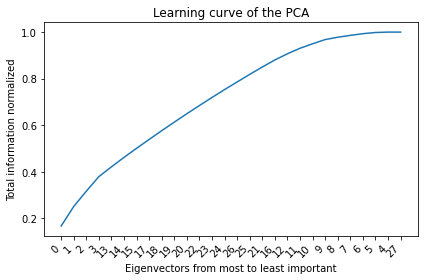

In [56]:
eigen_val_ma2mi
index_list

cumulative_eigen_val = []
acumulation = 0
for i in range(0,len(eigen_val_ma2mi)):
    acumulation += eigen_val_ma2mi[i]/len(eigen_val_ma2mi)
    cumulative_eigen_val.append(acumulation)

cumulative_eigen_val
index_list_str = []
for i in index_list:
    index_list_str.append(str(i))

plt.plot(index_list_str,cumulative_eigen_val)
plt.title('Learning curve of the PCA')
plt.xlabel('Eigenvectors from most to least important')
plt.ylabel('Total information normalized')
plt.xticks(rotation = 45, ha="right")
#plt.legend()
plt.tight_layout()
plt.savefig(figures_path+'Learning_Curve_PCA.png')
plt.show()

## 6. Fuzzy Learning <a class="anchor" id="6"></a>

Fuzzy learning simply means not using only boolean variables but more graduated ones. That is useful when predicting things that can have an unclear answer or are accompanied with a probability/confidence of the prediction.

## 7. Threshold to relevant data <a class="anchor" id="7"></a>

All this time in the study we did not know when to cut or what threshold value to give when talking about the improtance of certain parameters.

To solve that a first cutting process will be given in this section.

What we do in here is create random values for a given attrition value and calculate it's correlation. Doing that several times and calculating the mean of the maxima we expect to have the maximum threshold value of when a variable becomes significative or not (regarding the correlation value).

In [57]:
#crearemos 28 columnas random, de ellas escogemos la que tenga mayor correlación
#una vez tengamos todas las columnas más correlacionadas miraremos el valor medio
#cualquier variable de nuestro estudio que tenga menor correlación al valor que salga es descartable
#este es un primer método para obtener un threshold

threshold = data_n.Attrition
threshold

import random
random_lists = {}
for j in range(0,29):
    lista = []
    for i in range(0,len(threshold)):
        lista.append(random.random())
    random_lists[j] = lista
    
threshold = pd.concat([threshold,pd.DataFrame(random_lists)],axis=1)
threshold

,Attrition,0,1,2,3,4,5,6,7,8,...,19,20,21,22,23,24,25,26,27,28
0,1,0.378743,0.772886,0.580514,0.242266,0.714036,0.751217,0.543401,0.102017,0.352103,...,0.702487,0.279045,0.959050,0.126420,0.264418,0.288705,0.368499,0.017066,0.775441,0.103766
1,0,0.424362,0.846823,0.460167,0.529074,0.858985,0.112203,0.062031,0.560014,0.893242,...,0.549819,0.160559,0.106360,0.592370,0.434430,0.909142,0.250899,0.383495,0.991152,0.264115
2,1,0.513775,0.424484,0.767941,0.929876,0.390743,0.380480,0.024345,0.326594,0.656068,...,0.681968,0.070904,0.416077,0.037322,0.195997,0.890493,0.272142,0.165432,0.544558,0.885726
3,0,0.646417,0.695484,0.060044,0.861150,0.955301,0.536205,0.023885,0.937631,0.139263,...,0.444485,0.713636,0.818082,0.141237,0.422849,0.667620,0.831787,0.359656,0.402001,0.350110
4,0,0.762315,0.247594,0.825646,0.269837,0.603970,0.337727,0.336164,0.423687,0.253609,...,0.944166,0.071006,0.427523,0.044047,0.757447,0.533639,0.057653,0.636330,0.706999,0.020128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0,0.364210,0.707551,0.920085,0.616632,0.093516,0.310443,0.251848,0.180220,0.603375,...,0.753066,0.751585,0.148367,0.023678,0.242438,0.210240,0.246690,0.243209,0.913136,0.409302
1466,0,0.043534,0.733697,0.760343,0.484363,0.899993,0.740434,0.638188,0.763343,0.361920,...,0.668287,0.673507,0.155273,0.016618,0.872953,0.084193,0.761165,0.342360,0.060995,0.769788
1467,0,0.093778,0.581921,0.313425,0.920292,0.446370,0.961935,0.390908,0.289523,0.330907,...,0.763813,0.690090,0.080234,0.067141,0.556065,0.671768,0.672195,0.125460,0.182767,0.883013
1468,0,0.648637,0.029094,0.260840,0.326125,0.802891,0.951136,0.486595,0.229343,0.722294,...,0.256953,0.328124,0.888200,0.031738,0.939801,0.335949,0.807621,0.911079,0.558421,0.269802


##### creating_random_matrix <a class="anchor" id="d"></a>
Given a `DataFrame` with only the Attrition Column it returns a new DataFrame with 28 new columns, all of them with random values from the function `random.random()` and of the same lenght as the given Attrition `DataFrame`
##### correlation_max <a class="anchor" id="e"></a>
Given a `DataFrame` this funciton gives the maximum correlation value of all the columns respect to the Attrition one.

In [58]:
def creating_random_matrix(threshold):
    import random
    random_lists = {}
    for j in range(0,28):
        lista = []
        for i in range(0,len(threshold)):
            lista.append(random.random())
        random_lists[j] = lista

    threshold = pd.concat([threshold,pd.DataFrame(random_lists)],axis=1)
    return(threshold)

def correlation_max(data_n):
    #generalizo para todas las variables:

    lista_categorias = []

    for i in data_n:
        #print(i)
        if i != 'Attrition':
            lista_categorias.append(i)

    correlation_dic = {}
    lista_categorias_str = []

    for category in lista_categorias:
        try:
            r = attrition.corr(data_n[category]) # Pearson's r
            rho = attrition.corr(data_n[category], method='spearman')  # Spearman's rho
            tau = attrition.corr(data_n[category], method='kendall')   # Kendall's tau
            #print(r,rho,tau)
            correlation_dic[category] = [r,rho,tau]
        except:
            #print(category) #categories we need to make values of
            lista_categorias_str.append(category)
    
    max_corr = 0
    for category in correlation_dic:
        for correlation in correlation_dic[category]:
            if correlation > max_corr:
                max_corr = correlation

    return(max_corr)

##### mean_of_random  <a class="anchor" id="f"></a>
Given a `DataFrame` of only the a column with Attrition values and the number of calculations you want to do it returns the treshold value of correlation this Attrition `DataFrame`has. Ergo, it returns the mínimum correlation value a variable has to have in order to not be considered random. 

In [59]:
def mean_of_random(Attrition,n):
    max_correlation_values = []
    for i in range(0,n):
        random_matrix = creating_random_matrix(Attrition)
        max_corr = correlation_max(random_matrix)
        max_correlation_values.append(max_corr)
        
    mean = sum(max_correlation_values)/len(max_correlation_values)
    return(mean)
    
threshold_value = mean_of_random(data_n.Attrition,200)
threshold_value

0.05405948805374763

In [60]:
max_corr
#ahora podemos descartar todas esas variables con correlación inferior a threshold_value
discarted_variables = {}
max_corr_threshold = {}
for category in max_corr:
    if abs(max_corr[category]) <= threshold_value:
        discarted_variables[category] = max_corr[category]
    else:
        max_corr_threshold[category] = max_corr[category]
        
print(len(discarted_variables),'Variables descartades')
print(len(max_corr_threshold),'Variables que seguim considerant')

10 Variables descartades
18 Variables que seguim considerant


In [61]:
data.shape

(1470, 35)

## 8. Machine Learning for the data selection models <a class="anchor" id="8"></a>

Now once we have seen which categories are the most relevant or not we begin to introduce this selection to a Machine Learning device.

### 8.1 Machine Learning for Correlation <a class="anchor" id="8.1"></a>
We have done a first analysis of the variables that we need to keep given it's correlation values.
Now we're going to do the same but for a slightly changed DataFrame for the better use of the ML model.

In [62]:
max_corr_threshold

{'MaritalStatus': -0.1459853687036999,
 'BusinessTravel': 0.12763597530048107,
 'OverTime': 0.24611799424580436,
 'Age': -0.17121415703713502,
 'DailyRate': -0.05696969110631772,
 'DistanceFromHome': 0.07924818605616858,
 'EnvironmentSatisfaction': -0.10336897833793608,
 'JobInvolvement': -0.13001595678605354,
 'JobLevel': -0.19037042396815798,
 'JobSatisfaction': -0.10348112606902142,
 'MonthlyIncome': -0.19830500478881555,
 'StockOptionLevel': -0.17229579976178383,
 'TotalWorkingYears': -0.19900201964525882,
 'TrainingTimesLastYear': -0.059477798556420665,
 'WorkLifeBalance': -0.06393904721740905,
 'YearsAtCompany': -0.19041909827240788,
 'YearsInCurrentRole': -0.1806230299708929,
 'YearsWithCurrManager': -0.17535508134266475}

#### 8.1.1 Obtaining the DataFrame <a class="anchor" id="8.1.1"></a>

In [63]:
data_n

,MaritalStatus,BusinessTravel,OverTime,Gender,Attrition,Age,DailyRate,Department,DistanceFromHome,Education,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,StockOptionLevel1,Phase
0,0.0,0.5,1,-1,1,41,1102,Sales,1,2,...,0,8,0,1,6,4,0,5,1,1
1,1.0,1.0,0,1,0,49,279,Research & Development,8,1,...,1,10,3,3,10,7,1,7,2,1
2,0.0,0.5,1,1,1,37,1373,Research & Development,2,2,...,0,7,3,3,0,0,0,0,1,1
3,1.0,1.0,1,-1,0,33,1392,Research & Development,3,4,...,0,8,3,3,8,7,3,0,1,1
4,1.0,0.5,0,1,0,27,591,Research & Development,2,1,...,1,6,3,3,2,2,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,1.0,1.0,0,1,0,36,884,Research & Development,23,2,...,1,17,3,3,5,2,0,3,2,1
1466,1.0,0.5,0,1,0,39,613,Research & Development,6,1,...,1,9,5,3,7,7,1,7,2,1
1467,1.0,0.5,1,1,0,27,155,Research & Development,4,3,...,1,6,0,3,6,2,0,3,2,1
1468,1.0,1.0,0,1,0,49,1023,Sales,2,3,...,0,17,3,2,9,6,0,8,1,1


In [64]:
lista_categorias_str

['Department', 'EducationField', 'JobRole']

In [65]:
for i in lista_categorias_str:
    print(data_n.loc[:,i].value_counts())

Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64
Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: EducationField, dtype: int64
Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: JobRole, dtype: int64


##### dic_responses_of_category <a class="anchor" id="g"></a>

Given a `DataFrame` this function returns all the categories with it's possible answers in a dictionary format.

In [66]:
def dic_responses_of_category(DataFrame):
    #función que te da en formato de diccionario las posibles respuestas 
    #de cada categoría de un DataFrame dado
    #NECESARIO HABER COMPILADO LA FUNCIÓN: "llista_categories"
    
    list_variables = llista_categories(DataFrame)
    
    possible_answers = {}

    for category in list_variables:
        responses = DataFrame.loc[:,category].value_counts()
        answers = responses.index
        possible_answers[category] = list(answers)

    return(possible_answers)

In [67]:
possible_answers = dic_responses_of_category(data_n.loc[:,lista_categorias_str])
possible_answers

{'Department': ['Research & Development', 'Sales', 'Human Resources'],
 'EducationField': ['Life Sciences',
  'Medical',
  'Marketing',
  'Technical Degree',
  'Other',
  'Human Resources'],
 'JobRole': ['Sales Executive',
  'Research Scientist',
  'Laboratory Technician',
  'Manufacturing Director',
  'Healthcare Representative',
  'Manager',
  'Sales Representative',
  'Research Director',
  'Human Resources']}

In [68]:
data_OHE = data_n.loc[:,lista_categorias_str]
#data_OHE = pd.merge(data_n.loc[:,'EmployeeNumber'], data_OHE, left_index=True, right_index=True)
data_OHE

,Department,EducationField,JobRole
0,Sales,Life Sciences,Sales Executive
1,Research & Development,Life Sciences,Research Scientist
2,Research & Development,Other,Laboratory Technician
3,Research & Development,Life Sciences,Research Scientist
4,Research & Development,Medical,Laboratory Technician
...,...,...,...
1465,Research & Development,Medical,Laboratory Technician
1466,Research & Development,Medical,Healthcare Representative
1467,Research & Development,Life Sciences,Manufacturing Director
1468,Sales,Medical,Sales Executive


In [69]:
from sklearn.preprocessing import OneHotEncoder

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column 
encoder_df = pd.DataFrame(encoder.fit_transform(data_OHE[lista_categorias_str]).toarray())

#merge one-hot encoded columns back with original DataFrame
final_df = data_OHE.join(encoder_df)

#view final df
final_df

,Department,EducationField,JobRole,0,1,2,3,4,5,6,...,8,9,10,11,12,13,14,15,16,17
0,Sales,Life Sciences,Sales Executive,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Research & Development,Life Sciences,Research Scientist,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Research & Development,Other,Laboratory Technician,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Research & Development,Life Sciences,Research Scientist,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Research & Development,Medical,Laboratory Technician,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,Research & Development,Medical,Laboratory Technician,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1466,Research & Development,Medical,Healthcare Representative,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1467,Research & Development,Life Sciences,Manufacturing Director,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1468,Sales,Medical,Sales Executive,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [70]:
#we get how to rename each category in the OHE
renaming = []

for i in range(0,18):
    a = final_df.loc[final_df[i] == 1,'Department']
    b = final_df.loc[final_df[i] == 1,'EducationField']
    c = final_df.loc[final_df[i] == 1,'JobRole']
    
    if i in range(0,len(possible_answers['Department'])):
        renaming.append(a.iloc[0])
        #print('a')
    elif i in range(len(possible_answers['Department']),len(possible_answers['Department'])+len(possible_answers['EducationField'])):
        renaming.append(b.iloc[0])
        #print('b')
    else:
        renaming.append(c.iloc[0])
        #print('c')
    
#final_df.loc[79]
renaming

['Human Resources',
 'Research & Development',
 'Sales',
 'Human Resources',
 'Life Sciences',
 'Marketing',
 'Medical',
 'Other',
 'Technical Degree',
 'Healthcare Representative',
 'Human Resources',
 'Laboratory Technician',
 'Manager',
 'Manufacturing Director',
 'Research Director',
 'Research Scientist',
 'Sales Executive',
 'Sales Representative']

In [71]:
#drop column with str
final_df.drop(lista_categorias_str, axis=1, inplace=True)

final_df.columns = [renaming]
#renaming_dic = {}
#for i in range(0,18):
 #   renaming_dic[i] = renaming[i+1][0]
#final_df = final_df.rename(columns=renaming_dic)

final_df
#renaming_dic

,Human Resources,Research & Development,Sales,Human Resources,Life Sciences,Marketing,Medical,Other,Technical Degree,Healthcare Representative,Human Resources,Laboratory Technician,Manager,Manufacturing Director,Research Director,Research Scientist,Sales Executive,Sales Representative
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1466,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1467,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1468,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [72]:
llista_final = llista_categories(final_df)
llista_data = llista_categories(data_n.drop(columns=lista_categorias_str))
print(llista_final,llista_data)

[('Human Resources',), ('Research & Development',), ('Sales',), ('Human Resources',), ('Life Sciences',), ('Marketing',), ('Medical',), ('Other',), ('Technical Degree',), ('Healthcare Representative',), ('Human Resources',), ('Laboratory Technician',), ('Manager',), ('Manufacturing Director',), ('Research Director',), ('Research Scientist',), ('Sales Executive',), ('Sales Representative',)] ['MaritalStatus', 'BusinessTravel', 'OverTime', 'Gender', 'Attrition', 'Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'StockOptionLevel1', 'Phase']


In [73]:
llista_final_corregida = []
for i in llista_final:
    for j in i:
        llista_final_corregida.append(j)
llista_final_corregida
final_df.columns = llista_final_corregida
final_df

,Human Resources,Research & Development,Sales,Human Resources,Life Sciences,Marketing,Medical,Other,Technical Degree,Healthcare Representative,Human Resources,Laboratory Technician,Manager,Manufacturing Director,Research Director,Research Scientist,Sales Executive,Sales Representative
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1466,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1467,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1468,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [74]:
#hay tres categorías de Human Resources porque 3 variables categoricas tenían esta posible respuesta
#comprovamos que las tres columnas tengan la misma respuesta y así poder deshacernos de 2
final_df.loc[:,'Human Resources']

#creo una nueva columna para hacer la media de HumanResources
import numpy as np
final_df['Average HR'] = np.zeros(len(final_df))
diferentes = []

for i in range(0,len(final_df)):
    #values = final_df.loc[i,'Human Resources']
    value_list = [final_df.loc[i,'Human Resources'][0],
                  final_df.loc[i,'Human Resources'][1],
                  final_df.loc[i,'Human Resources'][2]]
    value = value_list[0]
    for j in value_list:
        if j != value:
            #print('Son valores diferentes')
            diferentes.append(i)
            #print(value_list)
            if value_list[0]+value_list[1]+value_list[2] == 1:
                final_df.loc[i,'Average HR'] = 0.0
            if value_list[0]+value_list[1]+value_list[2] == 2:
                final_df.loc[i,'Average HR'] = 1.0
                
final_df

,Human Resources,Research & Development,Sales,Human Resources,Life Sciences,Marketing,Medical,Other,Technical Degree,Healthcare Representative,Human Resources,Laboratory Technician,Manager,Manufacturing Director,Research Director,Research Scientist,Sales Executive,Sales Representative,Average HR
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1466,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1467,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1468,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [75]:
diferentes
final_df.loc[diferentes,['Human Resources','Average HR']]

final_df = final_df.drop(columns=['Human Resources'])
final_df

,Research & Development,Sales,Life Sciences,Marketing,Medical,Other,Technical Degree,Healthcare Representative,Laboratory Technician,Manager,Manufacturing Director,Research Director,Research Scientist,Sales Executive,Sales Representative,Average HR
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1466,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1467,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1468,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [76]:
data_OHE = pd.merge(data_n.drop(columns=lista_categorias_str), final_df, left_index=True, right_index=True)

data_OHE = data_OHE.drop(columns='EmployeeNumber')
#data_OHE = data_OHE.rename(columns={'EmployeeNumber_y' : 'EmployeeNumber'})
data_OHE

,MaritalStatus,BusinessTravel,OverTime,Gender,Attrition,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,...,Technical Degree,Healthcare Representative,Laboratory Technician,Manager,Manufacturing Director,Research Director,Research Scientist,Sales Executive,Sales Representative,Average HR
0,0.0,0.5,1,-1,1,41,1102,1,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,1.0,0,1,0,49,279,8,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.5,1,1,1,37,1373,2,2,4,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1,-1,0,33,1392,3,4,4,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.5,0,1,0,27,591,2,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,1.0,1.0,0,1,0,36,884,23,2,3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1466,1.0,0.5,0,1,0,39,613,6,1,4,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1467,1.0,0.5,1,1,0,27,155,4,3,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1468,1.0,1.0,0,1,0,49,1023,2,3,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [77]:
for i in data_OHE:
    print(i)

MaritalStatus
BusinessTravel
OverTime
Gender
Attrition
Age
DailyRate
DistanceFromHome
Education
EnvironmentSatisfaction
HourlyRate
JobInvolvement
JobLevel
JobSatisfaction
MonthlyIncome
MonthlyRate
NumCompaniesWorked
PercentSalaryHike
PerformanceRating
RelationshipSatisfaction
StockOptionLevel
TotalWorkingYears
TrainingTimesLastYear
WorkLifeBalance
YearsAtCompany
YearsInCurrentRole
YearsSinceLastPromotion
YearsWithCurrManager
StockOptionLevel1
Phase
Research & Development
Sales
Life Sciences
Marketing
Medical
Other
Technical Degree
Healthcare Representative
Laboratory Technician
Manager
Manufacturing Director
Research Director
Research Scientist
Sales Executive
Sales Representative
Average HR


In [78]:
a = ['MaritalStatus',
'BusinessTravel',
'OverTime',
'Gender',
'Attrition',
'Age',
'DailyRate',
'DistanceFromHome',
'Education',
'EnvironmentSatisfaction',
'HourlyRate',
'JobInvolvement',
'JobLevel',
'JobSatisfaction',
'MonthlyIncome',
'MonthlyRate',
'NumCompaniesWorked',
'PercentSalaryHike',
'PerformanceRating',
'RelationshipSatisfaction',
'StockOptionLevel',
'TotalWorkingYears',
'TrainingTimesLastYear',
'WorkLifeBalance',
'YearsAtCompany',
'YearsInCurrentRole',
'YearsSinceLastPromotion',
'YearsWithCurrManager',
'EmployeeNumber',
'Human Resources',
'Research & Development',
'Sales',
'Human Resources',
'Life Sciences',
'Marketing',
'Medical',
'Other',
'Technical Degree',
'Healthcare Representative',
'Human Resources',
'Laboratory Technician',
'Manager',
'Manufacturing Director',
'Research Director',
'Research Scientist',
'Sales Executive',
'Sales Representative']

print('Diferencias entre los dos DataFrames (ML code y este)')
print('Variables de este DataFrame que no están en ML')
for i in data_OHE:
    if i not in a:
        print(i)

print('----------')
print('Variables de ML que no están en este DataFrame')       
for i in a:
    if i not in data_OHE:
        print(i)

Diferencias entre los dos DataFrames (ML code y este)
Variables de este DataFrame que no están en ML
StockOptionLevel1
Phase
Average HR
----------
Variables de ML que no están en este DataFrame
EmployeeNumber
Human Resources
Human Resources
Human Resources


In [79]:
data_OHE = data_OHE.drop(columns=['StockOptionLevel1','Phase'])
data_OHE

,MaritalStatus,BusinessTravel,OverTime,Gender,Attrition,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,...,Technical Degree,Healthcare Representative,Laboratory Technician,Manager,Manufacturing Director,Research Director,Research Scientist,Sales Executive,Sales Representative,Average HR
0,0.0,0.5,1,-1,1,41,1102,1,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,1.0,0,1,0,49,279,8,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.5,1,1,1,37,1373,2,2,4,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1,-1,0,33,1392,3,4,4,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.5,0,1,0,27,591,2,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,1.0,1.0,0,1,0,36,884,23,2,3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1466,1.0,0.5,0,1,0,39,613,6,1,4,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1467,1.0,0.5,1,1,0,27,155,4,3,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1468,1.0,1.0,0,1,0,49,1023,2,3,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [80]:
#ahora miraremos la correlación respecto attrition de todas estas variables y descartaremos las que tienen 
#un valor inferior a threshold_value

corr_values,no_salieron_bien = correlation_attrition(data_OHE)
print(len(corr_values))
print('No salieron bien',no_salieron_bien)
corr_values
#no_salieron_bien

44
No salieron bien []


{'MaritalStatus': -0.1459853687036999,
 'BusinessTravel': 0.12763597530048107,
 'OverTime': 0.24611799424580436,
 'Gender': 0.029453253175141657,
 'Attrition': 1.0,
 'Age': -0.17121415703713502,
 'DailyRate': -0.05696969110631772,
 'DistanceFromHome': 0.07924818605616858,
 'Education': -0.031372819640049295,
 'EnvironmentSatisfaction': -0.10336897833793608,
 'HourlyRate': -0.006845549572139845,
 'JobInvolvement': -0.13001595678605354,
 'JobLevel': -0.19037042396815798,
 'JobSatisfaction': -0.10348112606902142,
 'MonthlyIncome': -0.19830500478881555,
 'MonthlyRate': 0.015257582997484679,
 'NumCompaniesWorked': 0.04349373905781359,
 'PercentSalaryHike': -0.023612035124358322,
 'PerformanceRating': 0.0028887517110807955,
 'RelationshipSatisfaction': -0.04587227888112664,
 'StockOptionLevel': -0.17229579976178383,
 'TotalWorkingYears': -0.19900201964525882,
 'TrainingTimesLastYear': -0.059477798556420665,
 'WorkLifeBalance': -0.06393904721740905,
 'YearsAtCompany': -0.19041909827240788,
 '

In [81]:
accepted_corr_values = {}

for category in corr_values:
    if category != 'Attrition':
        if abs(corr_values[category]) > threshold_value:
            accepted_corr_values[category] = corr_values[category]
        
print(len(accepted_corr_values))
accepted_corr_values

28


{'MaritalStatus': -0.1459853687036999,
 'BusinessTravel': 0.12763597530048107,
 'OverTime': 0.24611799424580436,
 'Age': -0.17121415703713502,
 'DailyRate': -0.05696969110631772,
 'DistanceFromHome': 0.07924818605616858,
 'EnvironmentSatisfaction': -0.10336897833793608,
 'JobInvolvement': -0.13001595678605354,
 'JobLevel': -0.19037042396815798,
 'JobSatisfaction': -0.10348112606902142,
 'MonthlyIncome': -0.19830500478881555,
 'StockOptionLevel': -0.17229579976178383,
 'TotalWorkingYears': -0.19900201964525882,
 'TrainingTimesLastYear': -0.059477798556420665,
 'WorkLifeBalance': -0.06393904721740905,
 'YearsAtCompany': -0.19041909827240788,
 'YearsInCurrentRole': -0.1806230299708929,
 'YearsWithCurrManager': -0.17535508134266475,
 'Research & Development': -0.08529292757679666,
 'Sales': 0.08085520213605389,
 'Marketing': 0.05578066572176361,
 'Technical Degree': 0.06935459476482023,
 'Healthcare Representative': -0.07869604964615459,
 'Laboratory Technician': 0.09829048545960264,
 'Man

In [82]:
categories = list(accepted_corr_values.keys())
categories.append('Attrition')
categories
df_ML_corr = data_OHE.loc[:,categories]
df_ML_corr

,MaritalStatus,BusinessTravel,OverTime,Age,DailyRate,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,...,Sales,Marketing,Technical Degree,Healthcare Representative,Laboratory Technician,Manager,Manufacturing Director,Research Director,Sales Representative,Attrition
0,0.0,0.5,1,41,1102,1,2,3,2,4,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1.0,1.0,0,49,279,8,3,2,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.5,1,37,1373,2,4,2,1,3,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
3,1.0,1.0,1,33,1392,3,4,3,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1.0,0.5,0,27,591,2,1,3,1,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,1.0,1.0,0,36,884,23,3,4,2,4,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1466,1.0,0.5,0,39,613,6,4,2,3,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1467,1.0,0.5,1,27,155,4,2,4,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1468,1.0,1.0,0,49,1023,2,4,2,2,2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


#### 8.1.2 Doing the RandomForest <a class="anchor" id="8.1.2"></a>

In [83]:
from random import sample
import math

df_ML_corr.drop(columns=['Attrition'])
sample(set(df_ML_corr.drop(columns=['Attrition'])),int(math.sqrt(len(df_ML_corr.columns))))

['Age', 'Manufacturing Director', 'WorkLifeBalance', 'Marketing', 'Sales']

In [84]:
from sklearn.ensemble import RandomForestClassifier

bosque = RandomForestClassifier(n_estimators = 100,#n_estimators = nº árboles
                               criterion = "entropy",#la altura de los parámetros en el árbol viene determinado al maximizar la entropía
                               max_features = "sqrt",#papers dicen que nº features es bueno que sea el sqrt
                               bootstrap = True,#proceso para obtener datos = subsets con replace y x featrues
                               max_samples = 2/3,#cúantos datos del DataFrame uso para los árboles
                               oob_score = True)

bosque.fit(df_ML_corr.drop(columns=['Attrition']).values, df_ML_corr.Attrition.values)

print('Accuracy with the same data')
print(bosque.score(df_ML_corr.drop(columns=['Attrition']).values, df_ML_corr.Attrition.values))
print('Accuracy of the model:')
print(bosque.oob_score_)

Accuracy with the same data
0.9857142857142858
Accuracy of the model:
0.8605442176870748


#### 8.1.3 Evaluation of the RandomForest <a class="anchor" id="8.1.3"></a>
##### 8.1.3.1 Train/Test Split <a class="anchor" id="8.1.3.1"></a>

In [85]:
# Import needed packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# If you're working in Jupyter Notebook, include the following so that plots will display:
%matplotlib inline

In [86]:
# Split dataset into features and target
y = df_ML_corr['Attrition']
X = df_ML_corr.drop(['Attrition'], axis=1)

In [87]:
# Split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

##### 8.1.3.1 Train/Test Split Evaluation <a class="anchor" id="8.1.3.2"></a>

In [88]:
bosque = RandomForestClassifier(n_estimators = 100,#n_estimators = nº árboles
                               criterion = "entropy",#la altura de los parámetros en el árbol viene determinado al maximizar la entropía
                               max_features = "sqrt",#papers dicen que nº features es bueno que sea el sqrt
                               bootstrap = True,#proceso para obtener datos = subsets con replace y x featrues
                               max_samples = 1,#cúantos datos del DataFrame uso para los árboles
                               oob_score = True)

bosque.fit(X_train, y_train)

# Instantiate and fit the RandomForestClassifier (different version)
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier()

In [89]:
# Make predictions for the test set
y_pred_test = bosque.predict(X_test)
y_pred_test2 = forest.predict(X_test)

In [90]:
# View accuracy score
print('Accuracy Score bosque')
print(accuracy_score(y_test, y_pred_test))
print('Accuracy Score forest')
print(accuracy_score(y_test, y_pred_test2))

Accuracy Score bosque
0.8396739130434783
Accuracy Score forest
0.8695652173913043


In [91]:
# View confusion matrix for test data and predictions
print('Resultado muy malo de bosque, predice todo igual')
print(confusion_matrix(y_test, y_pred_test))
print('Resultado de forest no predice todo igual')
print(confusion_matrix(y_test, y_pred_test2))

Resultado muy malo de bosque, predice todo igual
[[309   0]
 [ 59   0]]
Resultado de forest no predice todo igual
[[303   6]
 [ 42  17]]


#### 8.1.4 Improvement of RandomForest <a class="anchor" id="8.1.4"></a>
A partir de ahora siempre empezar ya el RandomForest con UnderSampling ya que los resultados siempre son mejores.
##### 8.1.4.1 Balancing Data <a class="anchor" id="8.1.4.1"></a>
**Undersampling**, we make that attrition values 1 and 0 have the same value count.

In [92]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

rus = RandomUnderSampler(replacement=True)
train_arr = np.asarray(X_train)
sol_arr = np.asarray(y_train.values)

train_uni, sol_uni = rus.fit_resample(train_arr, sol_arr)

train_df_new = pd.DataFrame(train_uni)
sol_df_new = pd.DataFrame(sol_uni)

In [93]:
#train_df_new
#sol_df_new

In [94]:
#ML model
bosque.fit(train_df_new, sol_df_new)
forest.fit(train_df_new, sol_df_new)

RandomForestClassifier()

In [95]:
# Make predictions for the test set
y_pred_test = bosque.predict(X_test)
y_pred_test2 = forest.predict(X_test)

In [96]:
# View accuracy score
print('Accuracy Score bosque')
print(accuracy_score(y_test, y_pred_test))
# View confusion matrix for test data and predictions
print('Resultado bosque muy malo, predice todo igual')
print(confusion_matrix(y_test, y_pred_test))

# View accuracy score
print('Accuracy Score forest')
print(accuracy_score(y_test, y_pred_test2))
# View confusion matrix for test data and predictions
print('Resultado forest predice todo igual')
print(confusion_matrix(y_test, y_pred_test2))


Accuracy Score bosque
0.8396739130434783
Resultado bosque muy malo, predice todo igual
[[309   0]
 [ 59   0]]
Accuracy Score forest
0.6793478260869565
Resultado forest predice todo igual
[[202 107]
 [ 11  48]]


##### draw_confusion_and_metrics <a class="anchor" id="i"></a>
Function that, given the correct values (y), the predicted ones (yhat) the labels of the confusion matrix and the title of the confusion matrix returns:
- Confusion matrix
- Values of all the following metrics:
    - precision
    - recall  
    - f1-score
    - sensitivity
    - specificity
    - positive predicted value
    - negative predicted value
    - accuracy

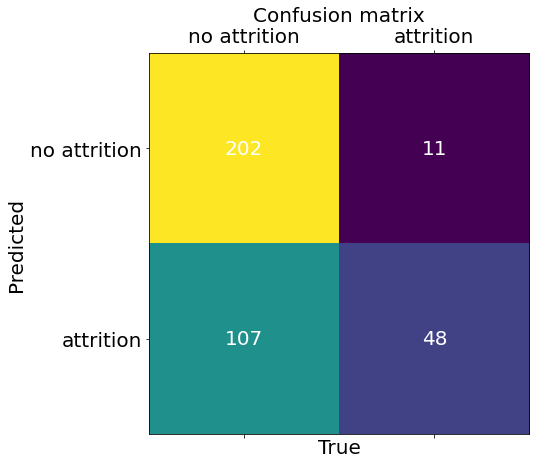

              precision    recall  f1-score   support

           0       0.95      0.65      0.77       309
           1       0.31      0.81      0.45        59

    accuracy                           0.68       368
   macro avg       0.63      0.73      0.61       368
weighted avg       0.85      0.68      0.72       368

sensitivity =  0.9483568075117371
specificity =  0.3096774193548387
pos. pred. val. =  0.6537216828478964
neg. pred. val. =  0.8135593220338984
accuracy =  0.6793478260869565
F1_score =  0.44859813084112155


In [97]:
def draw_confusion_and_metrics(y,yhat,labels,Title):
    import matplotlib.pyplot as plt
    from sklearn import metrics
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    %matplotlib inline
    
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm.T)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in range(2):
        for j in range(2):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
    fig.set_size_inches(7,7)
    plt.savefig(figures_path+Title+'.png')
    plt.show()
    print (metrics.classification_report(y,yhat))
    
    from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
    
    #recall or sensitivity
    sensitivity = confusion_matrix(y,yhat)[0][0]/(confusion_matrix(y,yhat)[0][0]+confusion_matrix(y,yhat)[1][0])
    #specificity
    specificity = confusion_matrix(y,yhat)[1][1]/(confusion_matrix(y,yhat)[1][1]+confusion_matrix(y,yhat)[0][1])
    #precision
    positive_prediction_value = confusion_matrix(y,yhat)[0][0]/(confusion_matrix(y,yhat)[0][0]+confusion_matrix(y,yhat)[0][1])
    negative_prediction_value = confusion_matrix(y,yhat)[1][1]/(confusion_matrix(y,yhat)[1][1]+confusion_matrix(y,yhat)[1][0])
    #accuracy
    all_parts = confusion_matrix(y,yhat)[0][0]+confusion_matrix(y,yhat)[0][1]+confusion_matrix(y,yhat)[1][0]+confusion_matrix(y,yhat)[1][1]
    accuracy = (confusion_matrix(y,yhat)[0][0]+confusion_matrix(y,yhat)[1][1])/all_parts

    print('sensitivity = ',sensitivity)
    print('specificity = ',specificity)
    print('pos. pred. val. = ',positive_prediction_value)
    print('neg. pred. val. = ',negative_prediction_value)
    print('accuracy = ',accuracy)
    
    f1_score_number = f1_score(y,yhat)

    print("F1_score = ", f1_score_number)



draw_confusion_and_metrics(y_test,y_pred_test2,['no attrition', 'attrition'],'CorrConfMatrix')

### 8.2 Machine Learning for PCA <a class="anchor" id="8.2"></a>

In [111]:
#añadimos la columna de attrition igual que el DataFrame data_n
#ya que el valor de índice se conserva para el nuevo DataFrame
FDS_PCA = pd.concat([FDS_PCA,data_n.Attrition],axis=1)

feature_vector
FDS_PCA

#este FDS_PCA y feature_vector podrían ser diferentes si uno decide utilizar un threshold diferente
#ya sea escogiendo perder un % de información diferente o cortando la "learning curve" en un punto diferente

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,Attrition
0,0.479057,0.790697,1.961593,-2.507494,1.411353,-1.302303,2.056028,-0.732154,-1.116348,0.668742,...,-0.492184,0.970382,0.268826,-0.583079,-1.309677,-0.690057,0.623356,-1.041441,0.708328,1
1,-0.706340,-1.374404,0.885943,1.716265,0.299007,0.843608,-1.074829,-1.619983,0.516925,-1.357505,...,0.970018,-0.975450,0.091445,0.399330,1.079500,-1.817311,1.104111,-0.986076,-1.607047,0
2,-0.263759,1.044813,-1.162004,-1.004287,1.113238,-0.185971,1.890628,-1.731737,-0.030660,1.162058,...,-0.449307,1.615443,-1.068242,0.524002,0.099061,1.582503,-0.375969,-1.155559,1.079726,1
3,-1.827598,0.723189,-0.212622,0.187477,-0.423863,-1.442324,1.200887,0.626076,0.222091,-0.274227,...,0.017436,0.722884,-2.275168,-0.728384,-1.043650,-0.600959,-0.604233,0.672243,0.181808,0
4,-1.257731,0.674913,-0.662918,-1.763371,-1.924798,-0.264105,-0.803748,-1.440599,1.054603,0.401145,...,0.101291,-0.241850,1.082006,-1.087665,0.345225,0.516304,1.347728,-1.926437,-0.378202,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,-1.492948,0.476833,-0.480315,0.271201,-1.136556,0.185016,-0.428784,-0.575465,0.390818,-1.065578,...,0.266048,-0.863708,0.306995,1.280493,-0.094475,0.894694,0.007462,-1.012918,-0.865899,0
1466,0.745692,1.070093,-0.282046,-1.432879,-0.551492,1.061998,-1.570083,-1.608679,0.070621,-0.292773,...,-0.532423,-0.438646,-1.192610,0.143078,1.449161,-1.261933,1.091747,0.890245,-0.899997,0
1467,0.278057,-2.473337,0.052965,0.662501,-1.080236,0.407806,-0.608251,-1.458329,-1.026474,-0.116569,...,-0.208475,-1.120762,0.206703,-0.446380,-2.549575,0.058618,-1.018124,-1.201172,0.504352,0
1468,-0.517068,0.511410,-0.242124,0.113872,0.764499,-0.688810,-0.696861,-0.158198,1.016929,-0.390714,...,1.309472,0.781707,-1.428243,-0.052194,0.564226,-0.898520,-0.122594,0.227148,-1.204102,0


#### 8.2.1 Doing the RandomForest <a class="anchor" id="8.2.1"></a>

In [117]:
# Import needed packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# If you're working in Jupyter Notebook, include the following so that plots will display:
%matplotlib inline

In [118]:
# Split dataset into features and target
y = FDS_PCA['Attrition']
X = FDS_PCA.drop(['Attrition'], axis=1)

# Split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [119]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

rus = RandomUnderSampler(replacement=True)
train_arr = np.asarray(X_train)
sol_arr = np.asarray(y_train.values)

train_uni, sol_uni = rus.fit_resample(train_arr, sol_arr)

train_df_new = pd.DataFrame(train_uni)
sol_df_new = pd.DataFrame(sol_uni)

In [120]:
forest.fit(train_df_new, sol_df_new)

RandomForestClassifier()

In [122]:
y_pred_test = forest.predict(X_test)

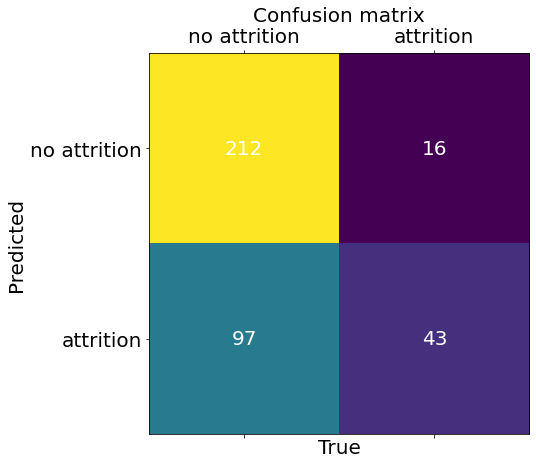

              precision    recall  f1-score   support

           0       0.93      0.69      0.79       309
           1       0.31      0.73      0.43        59

    accuracy                           0.69       368
   macro avg       0.62      0.71      0.61       368
weighted avg       0.83      0.69      0.73       368

sensitivity =  0.9298245614035088
specificity =  0.30714285714285716
pos. pred. val. =  0.686084142394822
neg. pred. val. =  0.7288135593220338
accuracy =  0.6929347826086957
F1_score =  0.43216080402010043


In [123]:
draw_confusion_and_metrics(y_test,y_pred_test,['no attrition', 'attrition'],'PCAConfMatrix')

### 8.3 Combining Correlation and PCA <a class="anchor" id="8.3"></a>

We create a `DataFrame` that simply concatenates the two previous ones and then does the machine learning on that new one.

#### 8.3.1 Creating the DataFrame <a class="anchor" id="8.3.1"></a>

In [136]:
df_corr_PCA = pd.concat([df_ML_corr.drop(columns='Attrition'),FDS_PCA],axis=1)
df_corr_PCA

,MaritalStatus,BusinessTravel,OverTime,Age,DailyRate,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,...,11,12,13,14,15,16,17,18,19,Attrition
0,0.0,0.5,1,41,1102,1,2,3,2,4,...,-0.492184,0.970382,0.268826,-0.583079,-1.309677,-0.690057,0.623356,-1.041441,0.708328,1
1,1.0,1.0,0,49,279,8,3,2,2,2,...,0.970018,-0.975450,0.091445,0.399330,1.079500,-1.817311,1.104111,-0.986076,-1.607047,0
2,0.0,0.5,1,37,1373,2,4,2,1,3,...,-0.449307,1.615443,-1.068242,0.524002,0.099061,1.582503,-0.375969,-1.155559,1.079726,1
3,1.0,1.0,1,33,1392,3,4,3,1,3,...,0.017436,0.722884,-2.275168,-0.728384,-1.043650,-0.600959,-0.604233,0.672243,0.181808,0
4,1.0,0.5,0,27,591,2,1,3,1,2,...,0.101291,-0.241850,1.082006,-1.087665,0.345225,0.516304,1.347728,-1.926437,-0.378202,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,1.0,1.0,0,36,884,23,3,4,2,4,...,0.266048,-0.863708,0.306995,1.280493,-0.094475,0.894694,0.007462,-1.012918,-0.865899,0
1466,1.0,0.5,0,39,613,6,4,2,3,1,...,-0.532423,-0.438646,-1.192610,0.143078,1.449161,-1.261933,1.091747,0.890245,-0.899997,0
1467,1.0,0.5,1,27,155,4,2,4,2,2,...,-0.208475,-1.120762,0.206703,-0.446380,-2.549575,0.058618,-1.018124,-1.201172,0.504352,0
1468,1.0,1.0,0,49,1023,2,4,2,2,2,...,1.309472,0.781707,-1.428243,-0.052194,0.564226,-0.898520,-0.122594,0.227148,-1.204102,0


#### 8.3.2 Doing the RandomForest <a class="anchor" id="8.3.2"></a>

In [141]:
# Split dataset into features and target
y = df_corr_PCA['Attrition']
X = df_corr_PCA.drop(['Attrition'], axis=1)
#SE TIENE QUE HACER PORQUE TENGO UN DATAFRAME QUE TIENE DOS TIPOS DE ÍNDICES (ALGUNOS CON INT OTROS CON STR)
#SI NO SE CAMBIA TE SALTA UN ERROR
X.columns = X.columns.astype(str)

# Split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [142]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

rus = RandomUnderSampler(replacement=True)
train_arr = np.asarray(X_train)
sol_arr = np.asarray(y_train)

train_uni, sol_uni = rus.fit_resample(train_arr, sol_arr)

train_df_new = pd.DataFrame(train_uni)
sol_df_new = pd.DataFrame(sol_uni)

In [143]:
forest.fit(train_df_new, sol_df_new)

RandomForestClassifier()

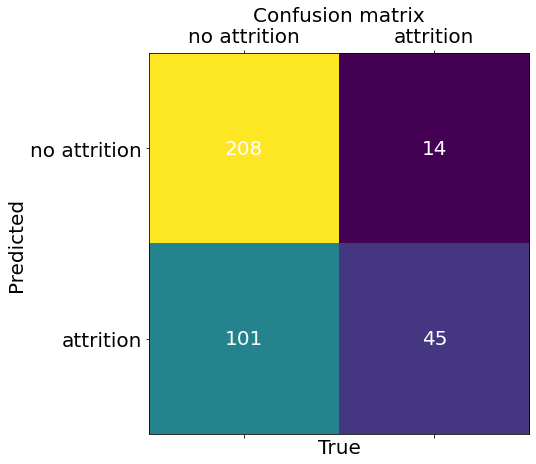

              precision    recall  f1-score   support

           0       0.94      0.67      0.78       309
           1       0.31      0.76      0.44        59

    accuracy                           0.69       368
   macro avg       0.62      0.72      0.61       368
weighted avg       0.84      0.69      0.73       368

sensitivity =  0.9369369369369369
specificity =  0.3082191780821918
pos. pred. val. =  0.6731391585760518
neg. pred. val. =  0.7627118644067796
accuracy =  0.6875
F1_score =  0.4390243902439025


In [144]:
y_pred_test = forest.predict(X_test)
draw_confusion_and_metrics(y_test,y_pred_test,['no attrition', 'attrition'],'CorrPCAConfMatrix')